# Geospatial Machine Learning for Mineral Exploration

This notebook provides a comprehensive walkthrough of analytical concepts and methods commonly used in geospatial data science for mineral exploration. It covers:

1. **Foundational Concepts**
   - Problem formulation
   - Data format considerations
   - EDA, transformations, and scaling
   - Missing data and imputation
   - Bias and data leakage (spatial autocorrelation)

2. **Analytical Methods**
   - Interpolation (IDW, Kriging)
   - Principal Component Analysis (PCA)
   - K-means clustering
   - Multivariate anomaly detection
   - Spectral halo classification
   - Supervised ML prospectivity mapping

---

## Setup and Configuration

### User Data Paths

**Provide paths to your data files below.** If left as `None`, synthetic data will be generated for demonstration purposes.

In [1]:
# =============================================================================
# USER CONFIGURATION - Provide paths to your data files
# =============================================================================

# Path to geochemistry point data (CSV, GeoJSON, or Parquet)
# Expected columns: X, Y coordinates + element concentrations
GEOCHEMISTRY_PATH = None  # e.g., "/path/to/geochem.csv"

# Path to continuous raster data (GeoTIFF)
# Used for interpolation, anomaly detection demos
RASTER_PATH = None  # e.g., "/path/to/elevation.tif"

# Path to multi-band spectral indices (directory with GeoTIFFs or single multi-band file)
# Used for spectral halo classification
SPECTRAL_INDICES_PATH = None  # e.g., "/path/to/spectral_indices/"

# Path to training data for supervised ML (NetCDF or GeoTIFF with features + target)
TRAINING_DATA_PATH = None  # e.g., "/path/to/training_data.nc"

# Path to known deposit locations (GeoJSON or Shapefile)
DEPOSITS_PATH = None  # e.g., "/path/to/deposits.geojson"

# =============================================================================
# If paths are not provided, synthetic data will be generated
USE_SYNTHETIC = all(p is None for p in [
    GEOCHEMISTRY_PATH, RASTER_PATH, SPECTRAL_INDICES_PATH, TRAINING_DATA_PATH
])

if USE_SYNTHETIC:
    print("No data paths provided - synthetic data will be generated for all examples.")
else:
    print("Using provided data paths where available.")

No data paths provided - synthetic data will be generated for all examples.


In [2]:
# =============================================================================
# Import required libraries
# =============================================================================

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Geospatial libraries
try:
    import rasterio
    import rioxarray as rxr
    RASTERIO_AVAILABLE = True
except ImportError:
    RASTERIO_AVAILABLE = False
    print("Warning: rasterio/rioxarray not available. Some raster operations will be limited.")

from shapely.geometry import Point, LineString, Polygon
from scipy import ndimage, stats
from scipy.spatial import KDTree, distance_matrix
from scipy.interpolate import griddata

# ML libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import silhouette_score, roc_curve, auc, precision_recall_curve

# Import helper functions
import helpers as h

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

print("Libraries loaded successfully.")

Libraries loaded successfully.


---

# Part 1: Foundational Concepts

---

## 1.1 Problem Formulation

Before applying any analytical method, it is critical to clearly define the problem. In mineral exploration, common problem types include:

### Types of Problems

| Problem Type | Description | Example Methods |
|-------------|-------------|------------------|
| **Interpolation** | Estimate values at unsampled locations | IDW, Kriging, Splines |
| **Classification** | Assign samples/pixels to discrete categories | K-means, Random Forest, Neural Networks |
| **Anomaly Detection** | Identify unusual patterns or outliers | Isolation Forest, LOF, ABOD |
| **Regression** | Predict continuous target variables | Linear Regression, Gradient Boosting |
| **Prospectivity Mapping** | Estimate probability of mineralization | Weights of Evidence, Logistic Regression, ML classifiers |

### Key Questions to Ask

1. **What is the target variable?** (e.g., presence/absence of mineralization, grade, alteration type)
2. **What spatial resolution is needed?** (point-based vs. gridded predictions)
3. **Is the problem supervised or unsupervised?**
4. **What are the constraints?** (computational, data availability, interpretability)
5. **How will results be validated?** (cross-validation, holdout, expert review)

### Supervised vs. Unsupervised Learning

- **Supervised**: Requires labeled training data (e.g., known deposit locations). Use when you have reliable ground truth.
- **Unsupervised**: No labels required. Use for exploration, pattern discovery, or when labels are unavailable.

### Spatial Considerations

Geospatial problems have unique challenges:
- **Spatial autocorrelation**: Nearby samples are often similar (violates independence assumption)
- **Edge effects**: Predictions near boundaries may be unreliable
- **Scale dependence**: Patterns may vary at different spatial scales
- **Coordinate reference systems (CRS)**: Must be consistent across datasets

---

## 1.2 Data Format Considerations

Geospatial data comes in two fundamental formats: **raster** and **vector**. Understanding their differences is essential for choosing appropriate methods.

In [3]:
# Generate synthetic data for demonstration
print("Generating synthetic demonstration data...\n")

# Generate vector geometries (points, lines, polygons)
gdf_points, gdf_lines, gdf_polygons = h.generate_synthetic_vector_geometries(
    n_points=50, n_lines=10, n_polygons=8,
    extent=(0, 1000, 0, 1000), random_state=42
)

# Generate raster data
raster_continuous, raster_extent = h.generate_synthetic_raster(
    shape=(100, 100), extent=(0, 1000, 0, 1000),
    n_anomalies=3, random_state=42
)

# Create categorical raster from continuous
raster_categorical = np.digitize(
    raster_continuous, 
    bins=np.percentile(raster_continuous, [25, 50, 75, 90])
)

print(f"Point features: {len(gdf_points)}")
print(f"Line features: {len(gdf_lines)}")
print(f"Polygon features: {len(gdf_polygons)}")
print(f"Raster shape: {raster_continuous.shape}")

Generating synthetic demonstration data...

Point features: 50
Line features: 10
Polygon features: 8
Raster shape: (100, 100)


### Raster vs. Vector Data

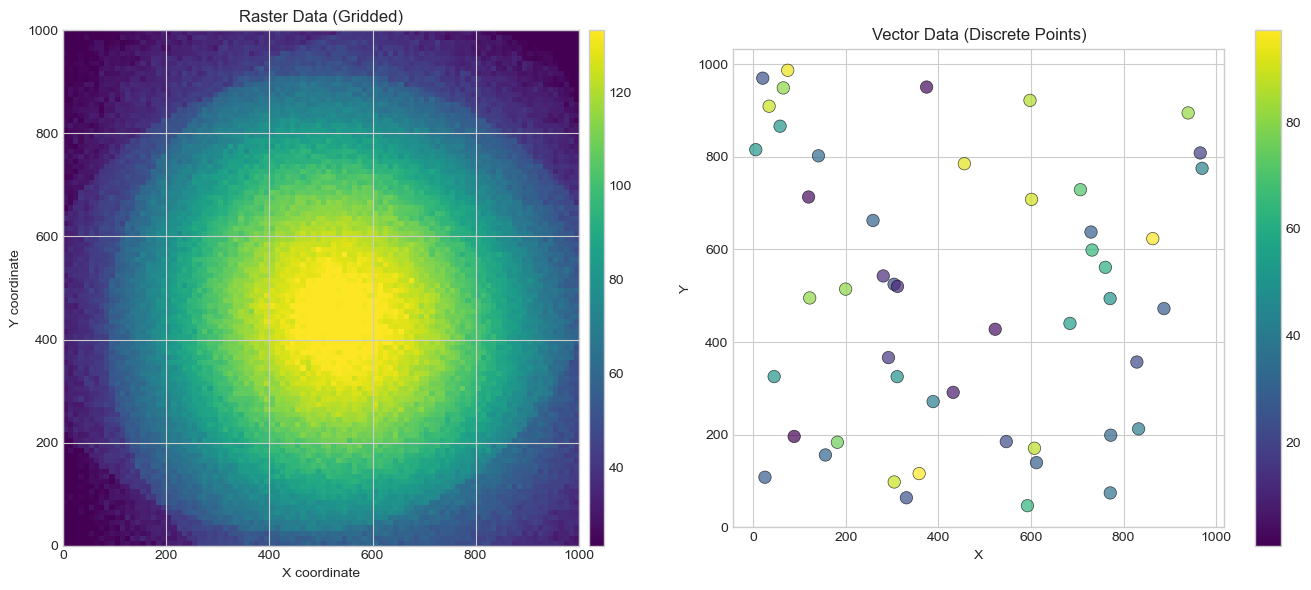


KEY DIFFERENCES:
----------------
RASTER:
  - Regular grid of cells (pixels)
  - Each cell has one value
  - Good for: continuous surfaces, remote sensing, elevation models
  - File formats: GeoTIFF, NetCDF, ASCII grid

VECTOR:
  - Discrete features with coordinates
  - Can have multiple attributes per feature
  - Good for: sample locations, boundaries, infrastructure
  - File formats: GeoJSON, Shapefile, GeoPackage



In [4]:
# Visualize raster vs vector
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Raster (gridded)
h.plot_raster(raster_continuous, ax=axes[0], title='Raster Data (Gridded)',
              extent=raster_extent)
axes[0].set_xlabel('X coordinate')
axes[0].set_ylabel('Y coordinate')

# Vector (discrete features)
h.plot_vector(gdf_points, column='value', ax=axes[1], 
              title='Vector Data (Discrete Points)', markersize=80)

plt.tight_layout()
plt.show()

print("""
KEY DIFFERENCES:
----------------
RASTER:
  - Regular grid of cells (pixels)
  - Each cell has one value
  - Good for: continuous surfaces, remote sensing, elevation models
  - File formats: GeoTIFF, NetCDF, ASCII grid

VECTOR:
  - Discrete features with coordinates
  - Can have multiple attributes per feature
  - Good for: sample locations, boundaries, infrastructure
  - File formats: GeoJSON, Shapefile, GeoPackage
""")

### Point vs. Line vs. Polygon Geometries

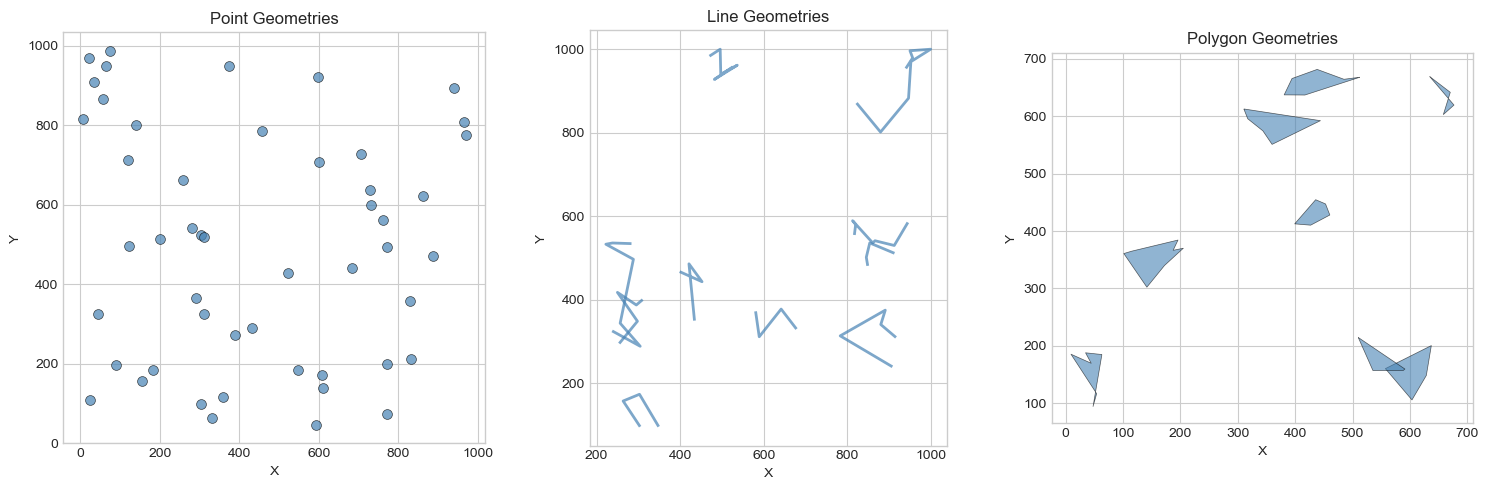


GEOMETRY TYPES:
---------------
POINTS:
  - Single (x, y) coordinate
  - Use for: sample locations, drill holes, occurrences
  - Example: geochemistry samples, GPS waypoints

LINES:
  - Sequence of connected coordinates
  - Use for: faults, roads, streams, traverse paths
  - Example: structural lineaments, drainage networks

POLYGONS:
  - Closed shapes defining areas
  - Use for: claim boundaries, lithology units, alteration zones
  - Example: permit areas, geological contacts



In [5]:
# Visualize different geometry types
fig, axes = h.plot_geometry_types(gdf_points, gdf_lines, gdf_polygons, figsize=(15, 5))
plt.show()

print("""
GEOMETRY TYPES:
---------------
POINTS:
  - Single (x, y) coordinate
  - Use for: sample locations, drill holes, occurrences
  - Example: geochemistry samples, GPS waypoints

LINES:
  - Sequence of connected coordinates
  - Use for: faults, roads, streams, traverse paths
  - Example: structural lineaments, drainage networks

POLYGONS:
  - Closed shapes defining areas
  - Use for: claim boundaries, lithology units, alteration zones
  - Example: permit areas, geological contacts
""")

### Continuous vs. Categorical Data

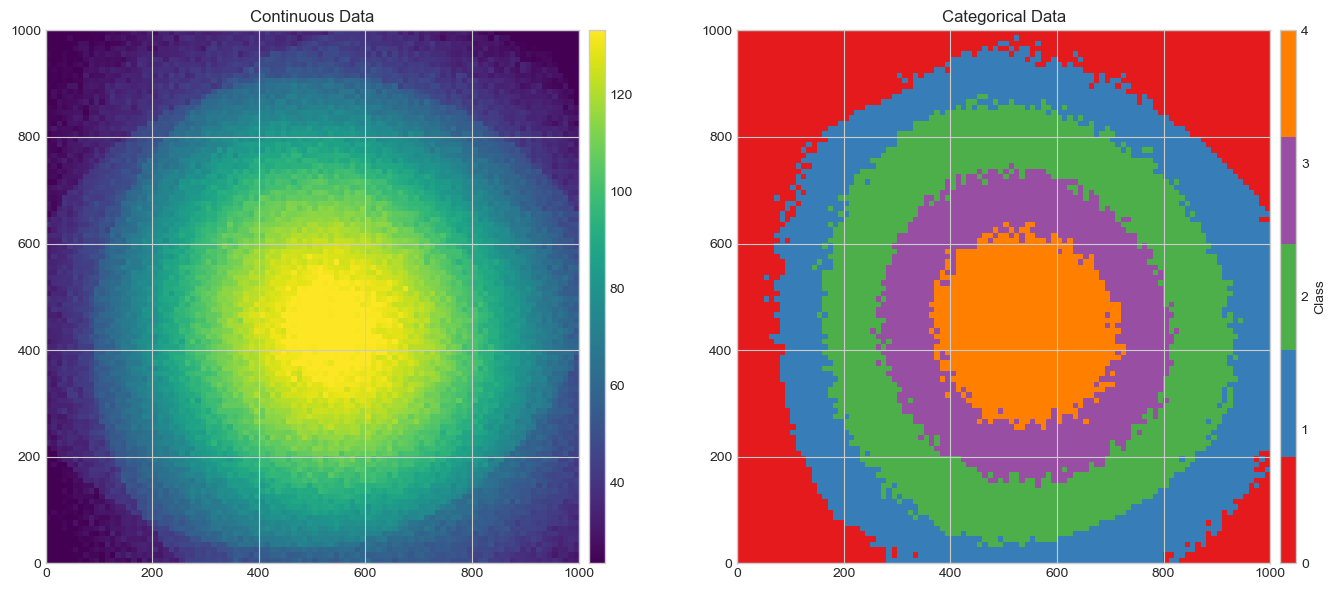


DATA TYPES:
-----------
CONTINUOUS:
  - Numeric values on a scale
  - Can take any value within range
  - Examples: elevation, grade, concentration, temperature
  - Analysis: regression, interpolation, statistics

CATEGORICAL:
  - Discrete classes or labels
  - Limited set of possible values
  - Examples: lithology, alteration type, rock code
  - Analysis: classification, clustering, mode statistics



In [6]:
# Visualize continuous vs categorical
fig, axes = h.plot_continuous_vs_categorical(
    raster_continuous, raster_categorical, 
    extent=raster_extent, figsize=(14, 6)
)
plt.show()

print("""
DATA TYPES:
-----------
CONTINUOUS:
  - Numeric values on a scale
  - Can take any value within range
  - Examples: elevation, grade, concentration, temperature
  - Analysis: regression, interpolation, statistics

CATEGORICAL:
  - Discrete classes or labels
  - Limited set of possible values
  - Examples: lithology, alteration type, rock code
  - Analysis: classification, clustering, mode statistics
""")

---

## 1.3 Exploratory Data Analysis (EDA), Transformations, and Scaling

Understanding your data before modeling is crucial. Geochemical data often requires transformation due to:
- Log-normal distributions
- Different measurement scales across elements
- Outliers from anomalous samples

In [7]:
# Load or generate geochemistry data
if GEOCHEMISTRY_PATH and Path(GEOCHEMISTRY_PATH).exists():
    # Load user data
    if GEOCHEMISTRY_PATH.endswith('.csv'):
        df_geochem = pd.read_csv(GEOCHEMISTRY_PATH)
        if 'X' in df_geochem.columns and 'Y' in df_geochem.columns:
            geometry = [Point(x, y) for x, y in zip(df_geochem['X'], df_geochem['Y'])]
            gdf_geochem = gpd.GeoDataFrame(df_geochem, geometry=geometry)
        else:
            gdf_geochem = gpd.GeoDataFrame(df_geochem)
    else:
        gdf_geochem = gpd.read_file(GEOCHEMISTRY_PATH)
    print(f"Loaded geochemistry data: {len(gdf_geochem)} samples")
else:
    # Generate synthetic geochemistry
    gdf_geochem = h.generate_synthetic_geochemistry(
        n_samples=500, n_elements=8, n_clusters=4, random_state=42
    )
    print(f"Generated synthetic geochemistry: {len(gdf_geochem)} samples")

# Display first few rows
print("\nData preview:")
display(gdf_geochem.head())

Generated synthetic geochemistry: 872 samples

Data preview:


Element_1  Element_2  Element_3  Element_4  Element_5  Element_6  \
0  106.007556  35.895964  11.799875  29.804511  10.588546  16.267201   
1  127.624554  47.447536  16.028754  41.739532   9.854062  10.656989   
2   96.828593  44.819035  18.427149  28.936062  14.890323  11.865232   
3  124.815634  55.228969  18.581552  34.773695  15.505088  11.486704   
4  100.314636  51.727101   9.826270  64.733331   9.344399   8.758404   

   Element_7  Element_8           X           Y  true_cluster  \
0  28.476151   2.408121  266.813490  142.746681             0   
1  32.013265   3.560250  419.318219  321.152525             0   
2  23.966521   4.122059  473.478753  266.093005             0   
3  28.196904   2.851020  416.768923  307.020928             0   
4  36.212180   3.759247  388.067267  414.494211             0   

                  geometry  
0  POINT (266.813 142.747)  
1  POINT (419.318 321.153)  
2  POINT (473.479 266.093)  
3  POINT (416.769 307.021)  
4  POINT (388.067 414.494)

In [8]:
# Get numeric columns (excluding coordinates)
element_cols = [c for c in gdf_geochem.select_dtypes(include=[np.number]).columns 
                if c not in ['X', 'Y', 'true_cluster']]

print(f"Element columns: {element_cols}")
print("\nBasic statistics:")
display(gdf_geochem[element_cols].describe())

Element columns: ['Element_1', 'Element_2', 'Element_3', 'Element_4', 'Element_5', 'Element_6', 'Element_7', 'Element_8']

Basic statistics:


Element_1   Element_2   Element_3   Element_4   Element_5   Element_6  \
count  872.000000  872.000000  872.000000  872.000000  872.000000  872.000000   
mean    24.889599   86.807238   16.660063   17.081370   31.302935   10.368776   
std     33.621365   67.637756    7.659803   13.549274   22.211516    9.302776   
min      1.638560    2.260482    3.843820    2.797964    2.656236    1.959417   
25%      8.350578   13.348934   10.860160    6.456730    9.398442    5.064088   
50%     11.589430   87.456213   15.774624    9.708874   32.864665    6.715307   
75%     20.466304  137.738403   21.076954   26.619369   46.875908   11.032507   
max    207.948935  326.223433   54.582736   76.117231  110.549061   69.145912   

        Element_7   Element_8  
count  872.000000  872.000000  
mean    33.396868    6.996447  
std     26.997032    7.016107  
min      5.710947    0.960794  
25%     18.427879    2.503157  
50%     25.435502    3.320452  
75%     34.893556   10.904356  
max    179.366894   40.739546

### Distribution Analysis

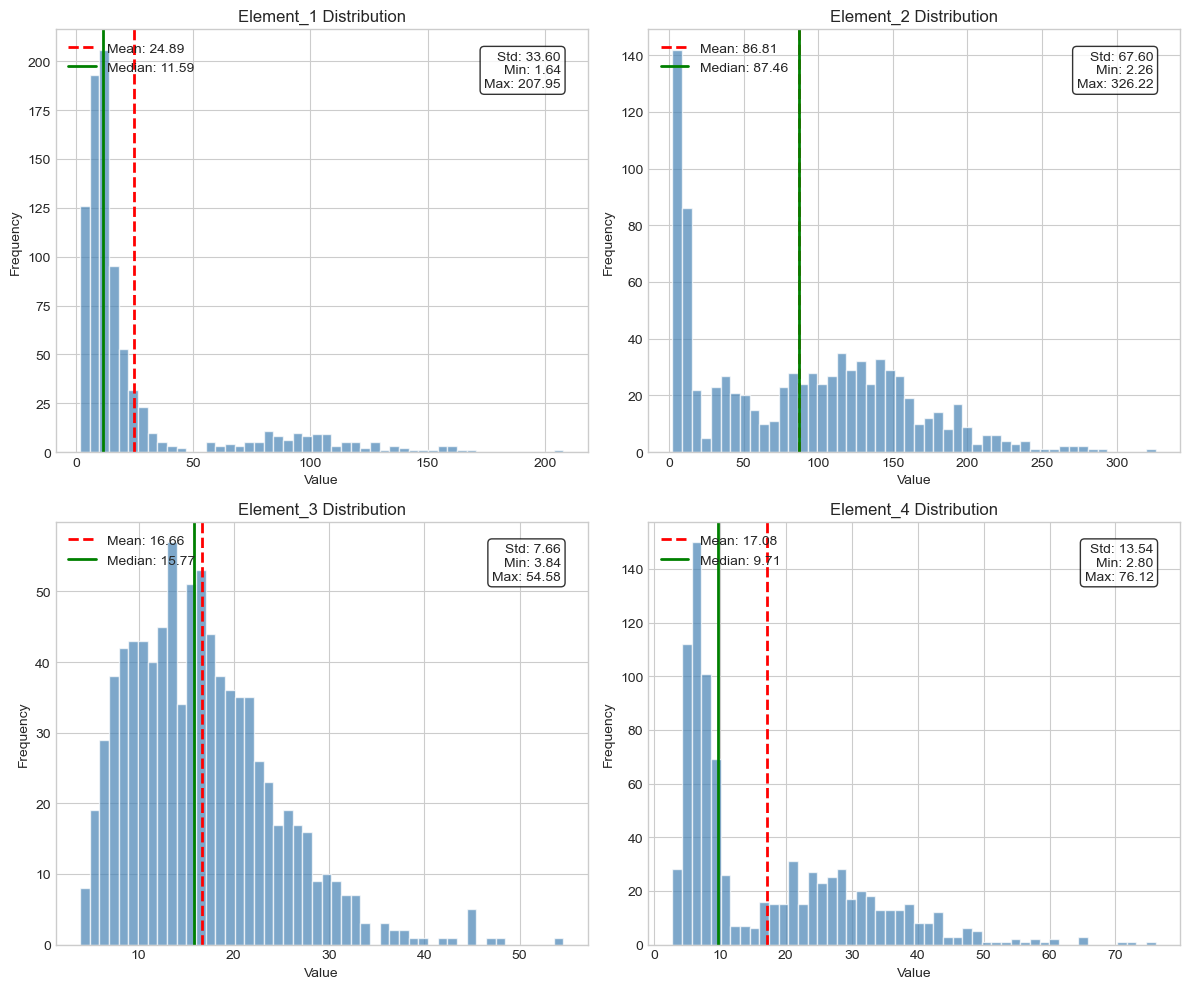

Note: Geochemical data often shows right-skewed (log-normal) distributions.


In [9]:
# Visualize distributions of first 4 elements
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(element_cols[:4]):
    h.plot_distribution(gdf_geochem[col], title=f'{col} Distribution', ax=axes[i])

plt.tight_layout()
plt.show()

print("Note: Geochemical data often shows right-skewed (log-normal) distributions.")

### Data Transformations

Common transformations for geochemical data:

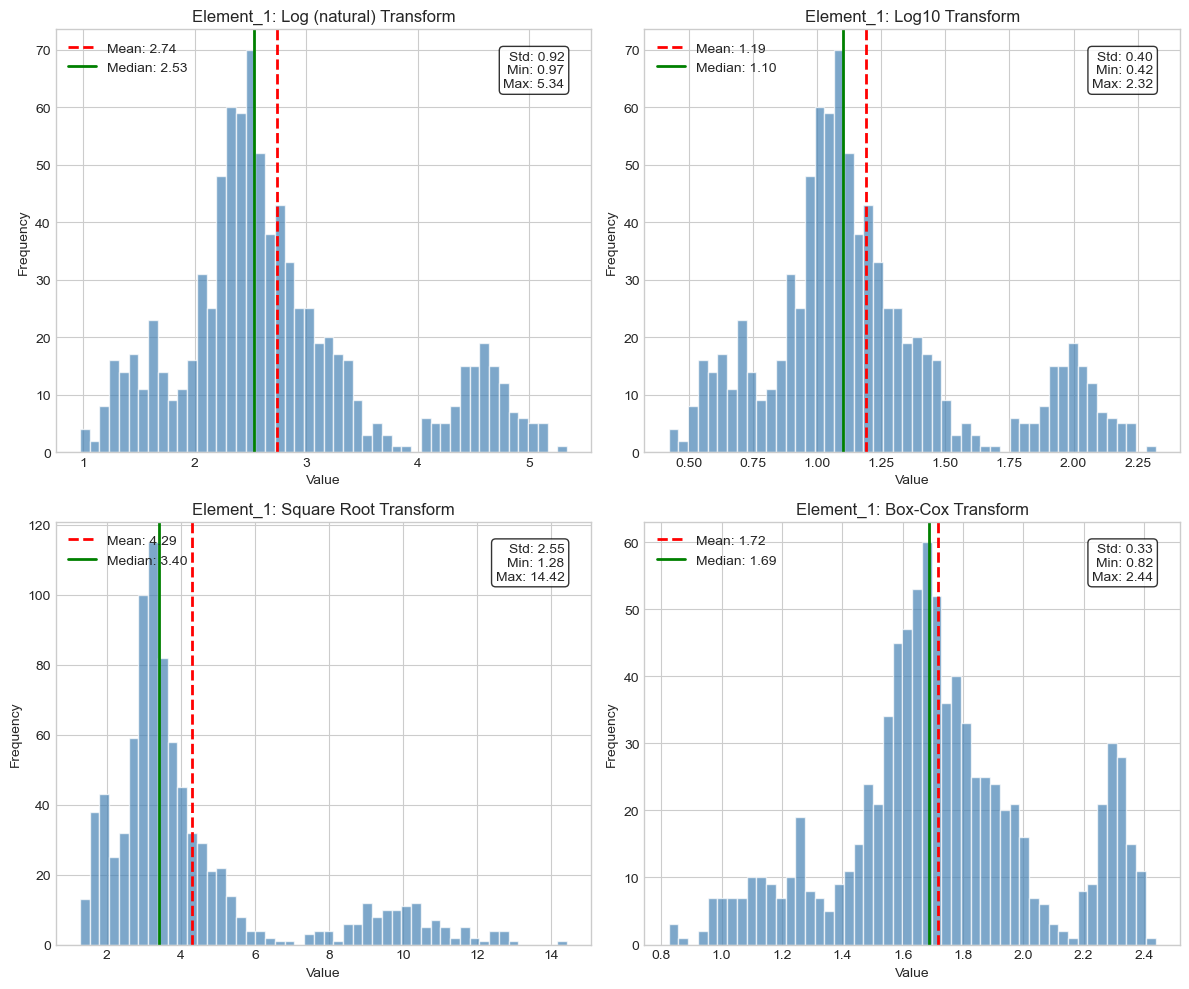


TRANSFORMATION GUIDELINES:
--------------------------
- Log transform: Best for log-normal data (most geochemistry)
- Square root: Moderate skewness, preserves zero values
- Box-Cox: Automatically finds optimal transformation
- Use transformed data for: correlation analysis, PCA, clustering
- Report original values for: interpretation, reporting grades



In [10]:
# Select one element for transformation demo
demo_col = element_cols[0]
original_data = gdf_geochem[demo_col].values

# Apply different transformations
transformations = {
    'Log (natural)': np.log(original_data + 1),  # +1 to handle zeros
    'Log10': np.log10(original_data + 1),
    'Square Root': np.sqrt(original_data),
    'Box-Cox': stats.boxcox(original_data + 1)[0]  # +1 required for positive values
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (name, transformed) in zip(axes, transformations.items()):
    h.plot_distribution(transformed, title=f'{demo_col}: {name} Transform', ax=ax)

plt.tight_layout()
plt.show()

print("""
TRANSFORMATION GUIDELINES:
--------------------------
- Log transform: Best for log-normal data (most geochemistry)
- Square root: Moderate skewness, preserves zero values
- Box-Cox: Automatically finds optimal transformation
- Use transformed data for: correlation analysis, PCA, clustering
- Report original values for: interpretation, reporting grades
""")

### Feature Scaling

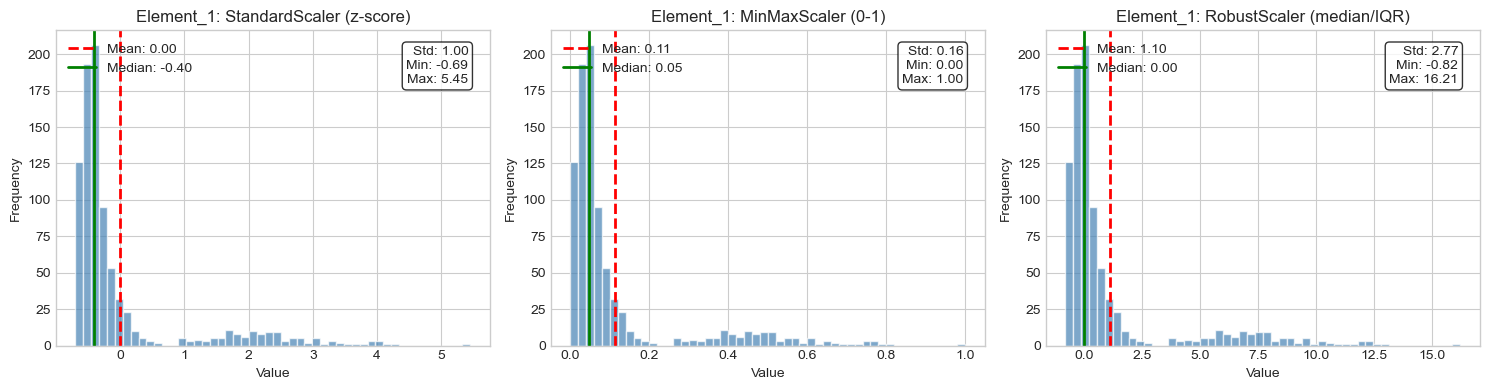


SCALING METHODS:
----------------
StandardScaler: Mean=0, Std=1. Sensitive to outliers.
MinMaxScaler: Range [0,1]. Preserves zero values, sensitive to outliers.
RobustScaler: Uses median/IQR. Best for data with outliers.

WHEN TO USE:
- PCA: StandardScaler (centers data at origin)
- K-means: StandardScaler or MinMaxScaler
- Neural networks: MinMaxScaler (bounded range)
- Data with outliers: RobustScaler



In [11]:
# Compare scaling methods
X = gdf_geochem[element_cols].values

scalers = {
    'StandardScaler (z-score)': StandardScaler(),
    'MinMaxScaler (0-1)': MinMaxScaler(),
    'RobustScaler (median/IQR)': RobustScaler()
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, scaler) in zip(axes, scalers.items()):
    X_scaled = scaler.fit_transform(X)
    
    # Plot distribution of first element after scaling
    h.plot_distribution(X_scaled[:, 0], title=f'{element_cols[0]}: {name}', 
                        ax=ax, show_stats=True)

plt.tight_layout()
plt.show()

print("""
SCALING METHODS:
----------------
StandardScaler: Mean=0, Std=1. Sensitive to outliers.
MinMaxScaler: Range [0,1]. Preserves zero values, sensitive to outliers.
RobustScaler: Uses median/IQR. Best for data with outliers.

WHEN TO USE:
- PCA: StandardScaler (centers data at origin)
- K-means: StandardScaler or MinMaxScaler
- Neural networks: MinMaxScaler (bounded range)
- Data with outliers: RobustScaler
""")

### Correlation Analysis

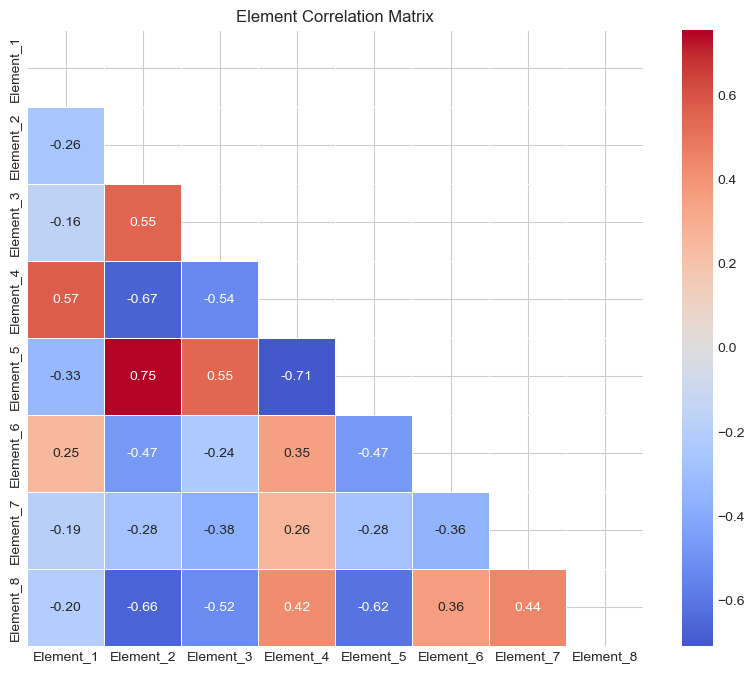


CORRELATION INTERPRETATION:
---------------------------
- High positive correlation: Elements associated in same process
- High negative correlation: Competitive/mutually exclusive processes
- Near zero: Independent processes

Use correlation to:
- Identify element associations (pathfinders)
- Detect multicollinearity (may need to remove redundant features)
- Understand geochemical signatures



In [12]:
# Correlation matrix
fig, ax = h.plot_correlation_matrix(gdf_geochem[element_cols], 
                                     title='Element Correlation Matrix',
                                     figsize=(10, 8))
plt.show()

print("""
CORRELATION INTERPRETATION:
---------------------------
- High positive correlation: Elements associated in same process
- High negative correlation: Competitive/mutually exclusive processes
- Near zero: Independent processes

Use correlation to:
- Identify element associations (pathfinders)
- Detect multicollinearity (may need to remove redundant features)
- Understand geochemical signatures
""")

---

## 1.4 Missing Data and Imputation

Missing data is common in geoscience datasets due to:
- Detection limits (below instrument sensitivity)
- Sample preparation issues
- Cost constraints (not all elements analyzed for all samples)

In [13]:
# Create a dataset with missing values for demonstration
gdf_missing = h.add_missing_data(
    gdf_geochem, 
    missing_pct=0.15,  # 15% missing
    columns=element_cols[:4],  # Only first 4 elements
    pattern='random',
    random_state=42
)

print("Missing data summary:")
print(gdf_missing[element_cols].isnull().sum())

Missing data summary:
Element_1    130
Element_2    130
Element_3    130
Element_4    130
Element_5      0
Element_6      0
Element_7      0
Element_8      0
dtype: int64


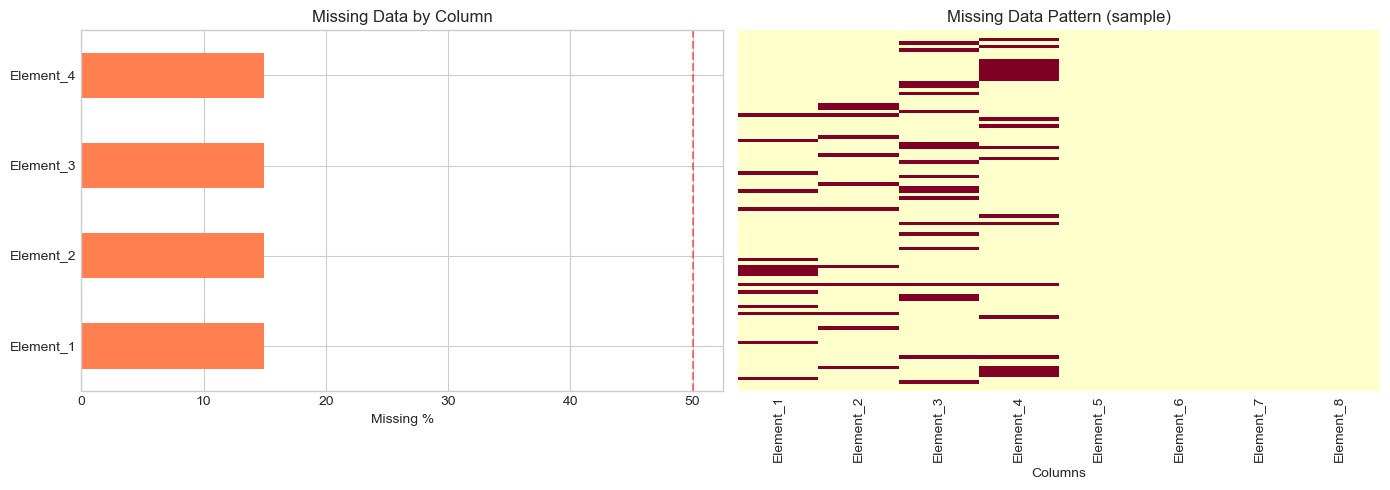

In [14]:
# Visualize missing data patterns
fig, axes = h.plot_missing_data_pattern(gdf_missing[element_cols], figsize=(14, 5))
plt.show()

### Imputation Methods

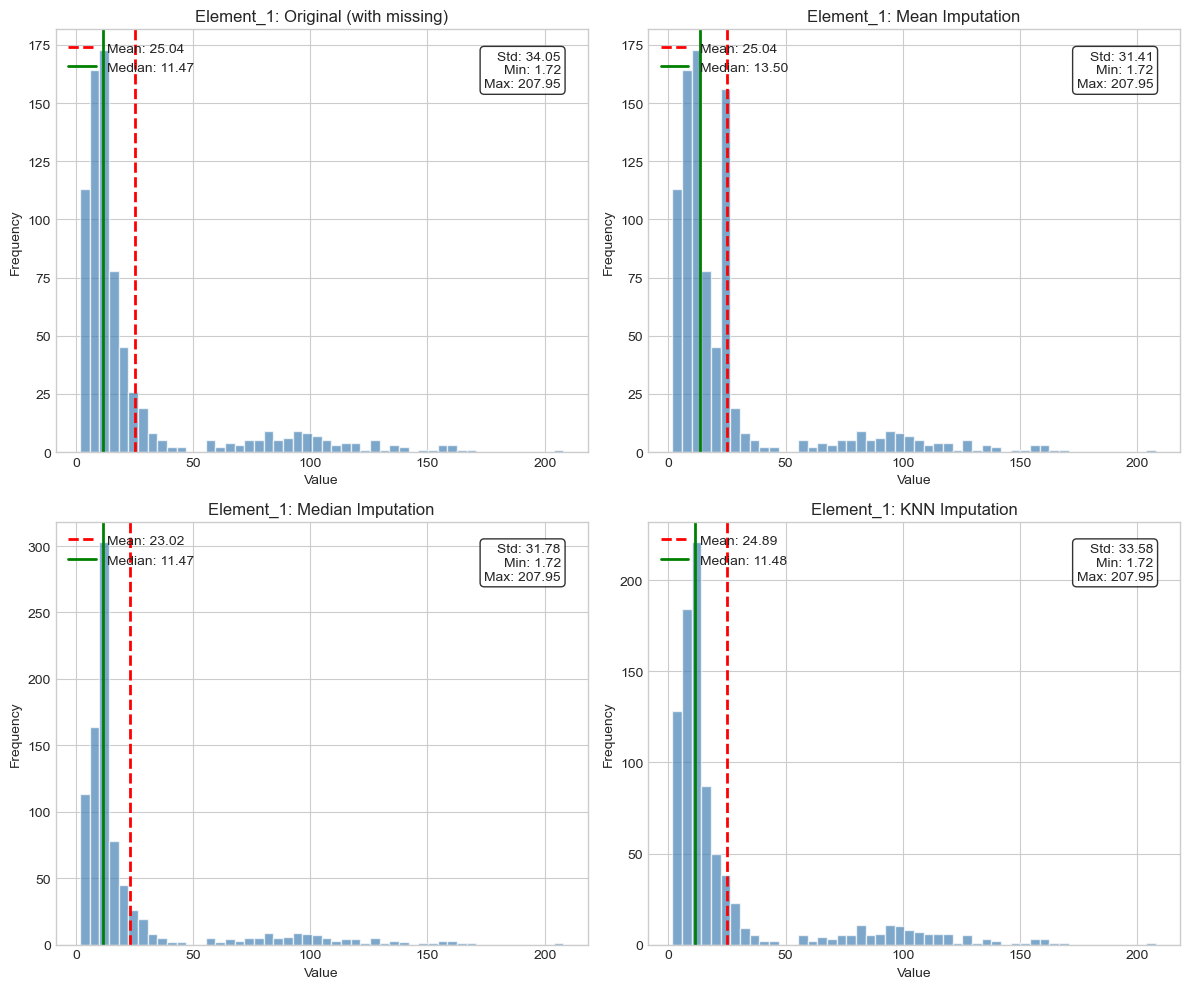


IMPUTATION METHODS:
-------------------
Mean/Median: Simple, fast, but reduces variance
KNN: Uses similar samples, preserves relationships better
Model-based: Use other features to predict missing values

BEST PRACTICES:
- Document what was imputed and how
- Consider uncertainty in imputed values
- For below-detection-limit: use detection_limit/2 or detection_limit/sqrt(2)
- Heavy missing (>30%): consider dropping feature or using methods that handle missing natively



In [15]:
# Select column with missing data
demo_col_missing = element_cols[0]
original_with_missing = gdf_missing[demo_col_missing].values.copy()

# Method 1: Mean imputation
imputer_mean = SimpleImputer(strategy='mean')
imputed_mean = imputer_mean.fit_transform(gdf_missing[[demo_col_missing]]).flatten()

# Method 2: Median imputation
imputer_median = SimpleImputer(strategy='median')
imputed_median = imputer_median.fit_transform(gdf_missing[[demo_col_missing]]).flatten()

# Method 3: KNN imputation (uses neighboring samples)
imputer_knn = KNNImputer(n_neighbors=5)
imputed_knn = imputer_knn.fit_transform(gdf_missing[element_cols])[:, 0]

# Compare results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

h.plot_distribution(original_with_missing[~np.isnan(original_with_missing)], 
                    title=f'{demo_col_missing}: Original (with missing)', ax=axes[0, 0])
h.plot_distribution(imputed_mean, title=f'{demo_col_missing}: Mean Imputation', ax=axes[0, 1])
h.plot_distribution(imputed_median, title=f'{demo_col_missing}: Median Imputation', ax=axes[1, 0])
h.plot_distribution(imputed_knn, title=f'{demo_col_missing}: KNN Imputation', ax=axes[1, 1])

plt.tight_layout()
plt.show()

print("""
IMPUTATION METHODS:
-------------------
Mean/Median: Simple, fast, but reduces variance
KNN: Uses similar samples, preserves relationships better
Model-based: Use other features to predict missing values

BEST PRACTICES:
- Document what was imputed and how
- Consider uncertainty in imputed values
- For below-detection-limit: use detection_limit/2 or detection_limit/sqrt(2)
- Heavy missing (>30%): consider dropping feature or using methods that handle missing natively
""")

---

## 1.5 Bias and Data Leakage: Spatial Autocorrelation

**Spatial autocorrelation** is the tendency for nearby locations to have similar values. This is a fundamental property of geospatial data ("Tobler's First Law of Geography") but creates challenges for ML:

- **Violates independence assumption**: ML algorithms assume i.i.d. (independent, identically distributed) samples
- **Inflates cross-validation scores**: Random train/test splits include nearby samples in both sets
- **Can cause data leakage**: Information from test locations "leaks" through correlated training samples

Demonstrating spatial autocorrelation in geochemical data...



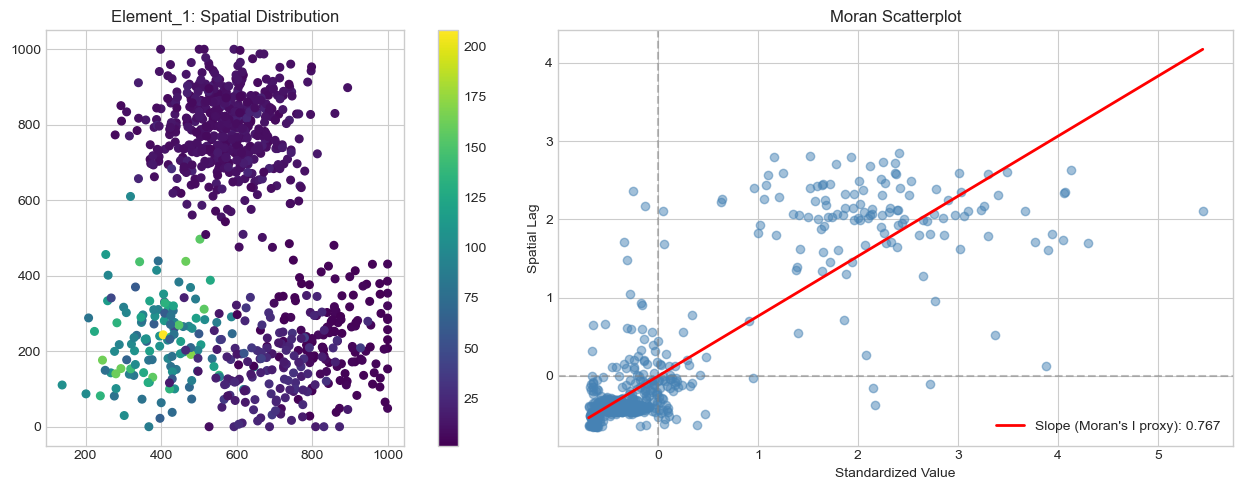

In [16]:
# Demonstrate spatial autocorrelation
print("Demonstrating spatial autocorrelation in geochemical data...\n")

# Use first element for demonstration
demo_element = element_cols[0]
values = gdf_geochem[demo_element].values

# Visualize spatial pattern and Moran scatterplot
fig, axes = h.plot_spatial_autocorrelation(
    gdf_geochem, values, 
    title=demo_element,
    figsize=(14, 5)
)
plt.show()

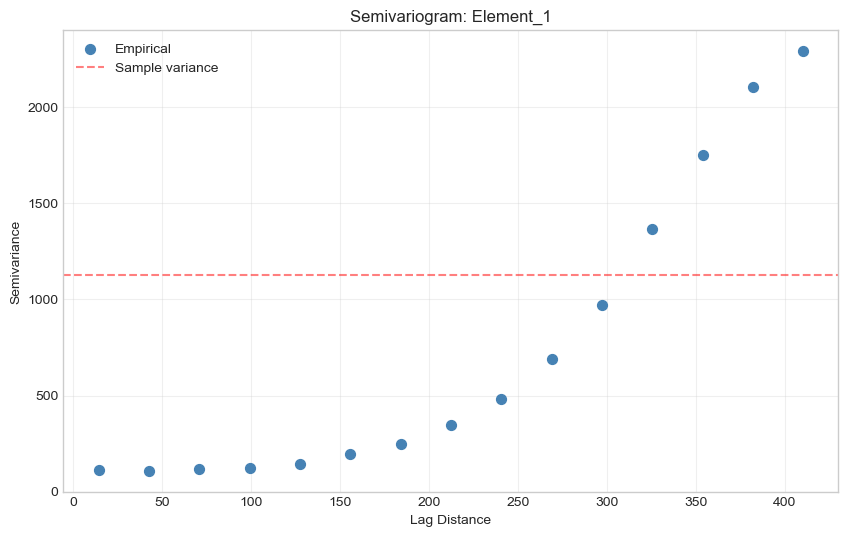


SEMIVARIOGRAM INTERPRETATION:
-----------------------------
- Rising curve: Spatial autocorrelation present
- Sill (plateau): Range beyond which samples are uncorrelated
- Nugget (y-intercept): Measurement error + micro-scale variation
- If flat: No spatial structure (random)

IMPLICATIONS FOR ML:
- Random cross-validation will be overoptimistic
- Use spatial cross-validation (block CV, leave-one-cluster-out)
- Checkerboard or buffer-based train/test splits



In [17]:
# Compute empirical semivariogram to show spatial structure
coords = np.column_stack([gdf_geochem.geometry.x, gdf_geochem.geometry.y])

def compute_semivariogram(coords, values, n_lags=15, max_lag=None):
    """Compute empirical semivariogram."""
    dist_matrix = distance_matrix(coords, coords)
    
    if max_lag is None:
        max_lag = np.percentile(dist_matrix, 50)
    
    lag_edges = np.linspace(0, max_lag, n_lags + 1)
    lag_centers = (lag_edges[:-1] + lag_edges[1:]) / 2
    
    semivariance = []
    for i in range(n_lags):
        mask = (dist_matrix > lag_edges[i]) & (dist_matrix <= lag_edges[i+1])
        if mask.sum() > 0:
            # Semivariance: 0.5 * mean of squared differences
            ii, jj = np.where(mask)
            sq_diff = (values[ii] - values[jj]) ** 2
            semivariance.append(0.5 * np.mean(sq_diff))
        else:
            semivariance.append(np.nan)
    
    return lag_centers, np.array(semivariance)

lags, semivar = compute_semivariogram(coords, values)

fig, ax = plt.subplots(figsize=(10, 6))
h.plot_semivariogram(lags, semivar, title=f'Semivariogram: {demo_element}', ax=ax)
ax.axhline(np.var(values), color='red', linestyle='--', alpha=0.5, label='Sample variance')
ax.legend()
plt.show()

print("""
SEMIVARIOGRAM INTERPRETATION:
-----------------------------
- Rising curve: Spatial autocorrelation present
- Sill (plateau): Range beyond which samples are uncorrelated
- Nugget (y-intercept): Measurement error + micro-scale variation
- If flat: No spatial structure (random)

IMPLICATIONS FOR ML:
- Random cross-validation will be overoptimistic
- Use spatial cross-validation (block CV, leave-one-cluster-out)
- Checkerboard or buffer-based train/test splits
""")

In [18]:
# Demonstrate the problem: Random vs Spatial CV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create a classification target based on spatial clusters
if 'true_cluster' in gdf_geochem.columns:
    y = gdf_geochem['true_cluster'].values
else:
    # Create synthetic target
    kmeans_spatial = KMeans(n_clusters=4, random_state=42)
    y = kmeans_spatial.fit_predict(coords)

X = gdf_geochem[element_cols].values

# Random CV
random_cv = KFold(n_splits=5, shuffle=True, random_state=42)
random_scores = []

for train_idx, test_idx in random_cv.split(X):
    clf = RandomForestClassifier(n_estimators=50, random_state=42)
    clf.fit(X[train_idx], y[train_idx])
    pred = clf.predict(X[test_idx])
    random_scores.append(accuracy_score(y[test_idx], pred))

# Spatial CV (simple block-based)
def spatial_cv_splits(coords, n_splits=5):
    """Create spatial CV splits based on X coordinate blocks."""
    x_coords = coords[:, 0]
    block_edges = np.percentile(x_coords, np.linspace(0, 100, n_splits + 1))
    
    for i in range(n_splits):
        test_mask = (x_coords >= block_edges[i]) & (x_coords < block_edges[i + 1])
        if i == n_splits - 1:  # Include right edge for last block
            test_mask = (x_coords >= block_edges[i]) & (x_coords <= block_edges[i + 1])
        train_mask = ~test_mask
        yield np.where(train_mask)[0], np.where(test_mask)[0]

spatial_scores = []
for train_idx, test_idx in spatial_cv_splits(coords, n_splits=5):
    if len(test_idx) > 0 and len(np.unique(y[train_idx])) > 1:
        clf = RandomForestClassifier(n_estimators=50, random_state=42)
        clf.fit(X[train_idx], y[train_idx])
        pred = clf.predict(X[test_idx])
        spatial_scores.append(accuracy_score(y[test_idx], pred))

print(f"Random CV Accuracy: {np.mean(random_scores):.3f} (+/- {np.std(random_scores):.3f})")
print(f"Spatial CV Accuracy: {np.mean(spatial_scores):.3f} (+/- {np.std(spatial_scores):.3f})")
print(f"\nOverestimation from random CV: {(np.mean(random_scores) - np.mean(spatial_scores)) * 100:.1f}%")

print("""
KEY TAKEAWAY:
-------------
Random CV typically overestimates performance on spatially autocorrelated data.
Always use spatial cross-validation for geospatial ML problems!
""")

Random CV Accuracy: 1.000 (+/- 0.000)
Spatial CV Accuracy: 1.000 (+/- 0.000)

Overestimation from random CV: 0.0%

KEY TAKEAWAY:
-------------
Random CV typically overestimates performance on spatially autocorrelated data.
Always use spatial cross-validation for geospatial ML problems!



---

# Part 2: Analytical Methods

This section covers common analytical methods used in mineral exploration data science.

---

## 2.1 Spatial Interpolation

Interpolation estimates values at unsampled locations based on nearby samples. Common methods:

- **Inverse Distance Weighting (IDW)**: Simple, deterministic, weights by distance
- **Kriging**: Geostatistical, uses spatial structure (semivariogram), provides uncertainty estimates

In [19]:
# Prepare data for interpolation
interp_element = element_cols[0]
sample_coords = np.column_stack([gdf_geochem.geometry.x, gdf_geochem.geometry.y])
sample_values = gdf_geochem[interp_element].values

# Create interpolation grid
grid_resolution = 50
x_range = (sample_coords[:, 0].min(), sample_coords[:, 0].max())
y_range = (sample_coords[:, 1].min(), sample_coords[:, 1].max())

grid_x = np.linspace(x_range[0], x_range[1], grid_resolution)
grid_y = np.linspace(y_range[0], y_range[1], grid_resolution)
grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)
grid_points = np.column_stack([grid_xx.flatten(), grid_yy.flatten()])

extent = (x_range[0], x_range[1], y_range[1], y_range[0])  # Note: y reversed for imshow

print(f"Interpolating {interp_element} from {len(sample_coords)} samples to {grid_resolution}x{grid_resolution} grid")

Interpolating Element_1 from 872 samples to 50x50 grid


### Inverse Distance Weighting (IDW)

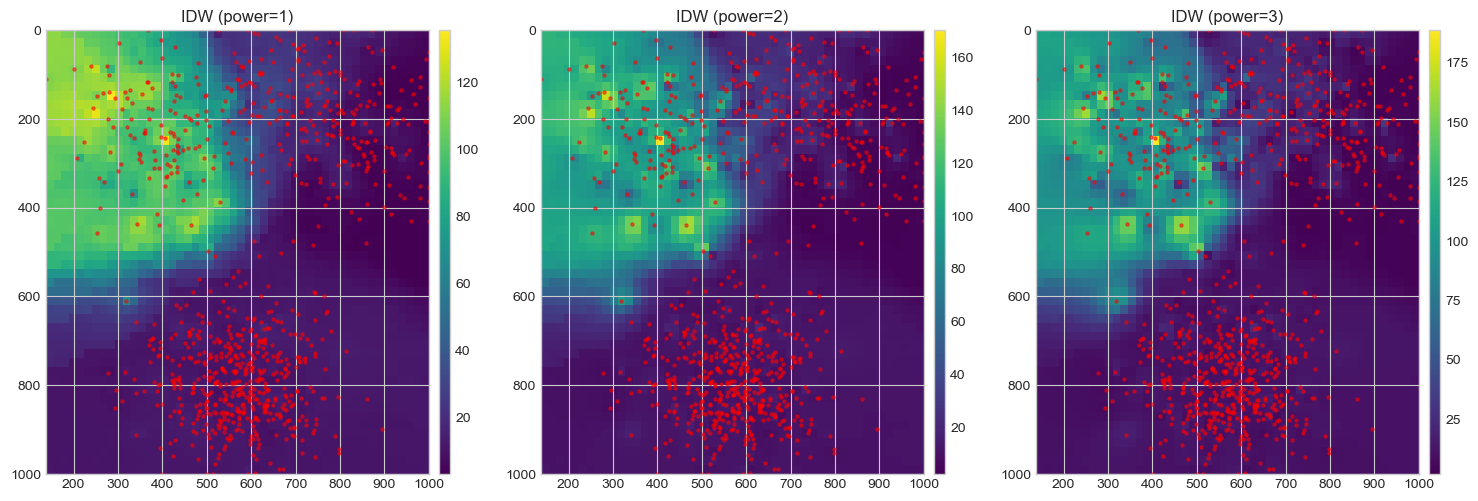


IDW PARAMETERS:
---------------
- Power=1: Smoother surface, more distant samples have influence
- Power=2: Standard choice, balanced
- Power=3+: Sharper features, more local influence
- n_neighbors: More neighbors = smoother surface



In [20]:
def idw_interpolation(sample_coords, sample_values, grid_points, power=2, n_neighbors=12):
    """Inverse Distance Weighting interpolation."""
    tree = KDTree(sample_coords)
    distances, indices = tree.query(grid_points, k=n_neighbors)
    
    # Avoid division by zero
    distances = np.maximum(distances, 1e-10)
    
    # Calculate weights
    weights = 1 / (distances ** power)
    weights_sum = weights.sum(axis=1, keepdims=True)
    weights_normalized = weights / weights_sum
    
    # Weighted average
    interpolated = np.sum(weights_normalized * sample_values[indices], axis=1)
    
    return interpolated

# Apply IDW with different power parameters
idw_p1 = idw_interpolation(sample_coords, sample_values, grid_points, power=1)
idw_p2 = idw_interpolation(sample_coords, sample_values, grid_points, power=2)
idw_p3 = idw_interpolation(sample_coords, sample_values, grid_points, power=3)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (idw_result, power) in zip(axes, [(idw_p1, 1), (idw_p2, 2), (idw_p3, 3)]):
    grid_z = idw_result.reshape(grid_resolution, grid_resolution)
    h.plot_raster(grid_z, ax=ax, title=f'IDW (power={power})', extent=extent, robust_stretch=False)
    ax.scatter(sample_coords[:, 0], sample_coords[:, 1], c='red', s=5, alpha=0.5)

plt.tight_layout()
plt.show()

print("""
IDW PARAMETERS:
---------------
- Power=1: Smoother surface, more distant samples have influence
- Power=2: Standard choice, balanced
- Power=3+: Sharper features, more local influence
- n_neighbors: More neighbors = smoother surface
""")

### Kriging (Ordinary Kriging)

Kriging uses the spatial structure (semivariogram) to weight samples and provides uncertainty estimates.

Fitted variogram parameters:
  Nugget: 0.00
  Sill: 2285.25
  Range: 820.98


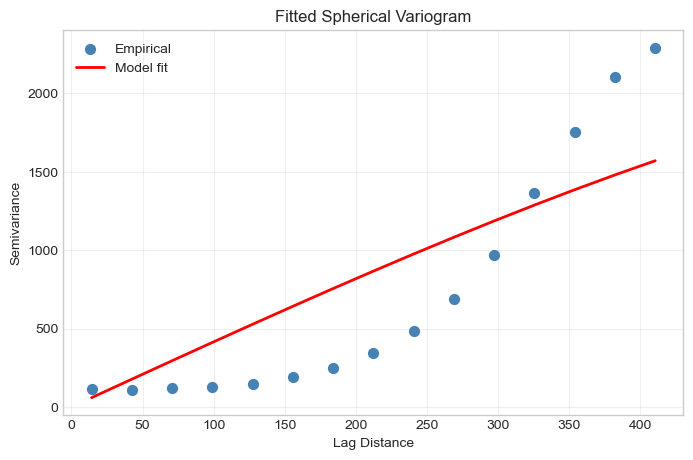

In [21]:
# Simple Ordinary Kriging implementation
def spherical_variogram(h, nugget, sill, range_param):
    """Spherical variogram model."""
    h = np.asarray(h)
    result = np.zeros_like(h, dtype=float)
    
    mask = h > 0
    h_norm = h[mask] / range_param
    
    within_range = h_norm <= 1
    result_temp = np.zeros_like(h_norm)
    result_temp[within_range] = nugget + (sill - nugget) * (1.5 * h_norm[within_range] - 0.5 * h_norm[within_range]**3)
    result_temp[~within_range] = sill
    
    result[mask] = result_temp
    return result

def fit_variogram(lags, semivar):
    """Simple variogram fitting."""
    from scipy.optimize import curve_fit
    
    # Remove NaN values
    valid = ~np.isnan(semivar)
    lags_clean = lags[valid]
    semivar_clean = semivar[valid]
    
    if len(lags_clean) < 3:
        return 0, np.max(semivar_clean), np.max(lags_clean)
    
    # Initial guesses
    nugget_init = semivar_clean[0] if semivar_clean[0] > 0 else 0
    sill_init = np.max(semivar_clean)
    range_init = lags_clean[np.argmax(semivar_clean > 0.95 * sill_init)] if any(semivar_clean > 0.95 * sill_init) else np.max(lags_clean) / 2
    
    try:
        popt, _ = curve_fit(
            spherical_variogram, lags_clean, semivar_clean,
            p0=[nugget_init, sill_init, range_init],
            bounds=([0, 0, 1], [sill_init, sill_init * 2, np.max(lags_clean) * 2]),
            maxfev=5000
        )
        return popt
    except:
        return nugget_init, sill_init, range_init

def ordinary_kriging(sample_coords, sample_values, grid_points, nugget, sill, range_param, n_neighbors=12):
    """Simple Ordinary Kriging implementation."""
    tree = KDTree(sample_coords)
    
    predictions = np.zeros(len(grid_points))
    variances = np.zeros(len(grid_points))
    
    for i, point in enumerate(grid_points):
        # Find nearest neighbors
        distances, indices = tree.query(point, k=n_neighbors)
        
        if np.min(distances) < 1e-10:  # Point coincides with sample
            predictions[i] = sample_values[indices[0]]
            variances[i] = 0
            continue
        
        local_coords = sample_coords[indices]
        local_values = sample_values[indices]
        
        # Build kriging system
        n = len(local_coords)
        K = np.zeros((n + 1, n + 1))
        
        # Covariance matrix (C = sill - variogram)
        for j in range(n):
            for k in range(n):
                dist = np.linalg.norm(local_coords[j] - local_coords[k])
                K[j, k] = sill - spherical_variogram(dist, nugget, sill, range_param)
        
        # Lagrange multiplier row/column
        K[n, :n] = 1
        K[:n, n] = 1
        K[n, n] = 0
        
        # Right-hand side
        k0 = np.zeros(n + 1)
        for j in range(n):
            dist = np.linalg.norm(local_coords[j] - point)
            k0[j] = sill - spherical_variogram(dist, nugget, sill, range_param)
        k0[n] = 1
        
        # Solve kriging system
        try:
            weights = np.linalg.solve(K, k0)
            predictions[i] = np.dot(weights[:n], local_values)
            variances[i] = sill - np.dot(weights[:n], k0[:n]) - weights[n]
        except:
            # Fall back to IDW
            w = 1 / (distances ** 2)
            predictions[i] = np.sum(w * local_values) / np.sum(w)
            variances[i] = np.var(local_values)
    
    return predictions, np.maximum(variances, 0)

# Fit variogram
lags, semivar = compute_semivariogram(sample_coords, sample_values)
nugget, sill, range_param = fit_variogram(lags, semivar)

print(f"Fitted variogram parameters:")
print(f"  Nugget: {nugget:.2f}")
print(f"  Sill: {sill:.2f}")
print(f"  Range: {range_param:.2f}")

# Plot fitted variogram
fig, ax = plt.subplots(figsize=(8, 5))
model_fit = spherical_variogram(lags, nugget, sill, range_param)
h.plot_semivariogram(lags, semivar, model_fit=model_fit, title='Fitted Spherical Variogram', ax=ax)
plt.show()

Running Ordinary Kriging (this may take a moment)...


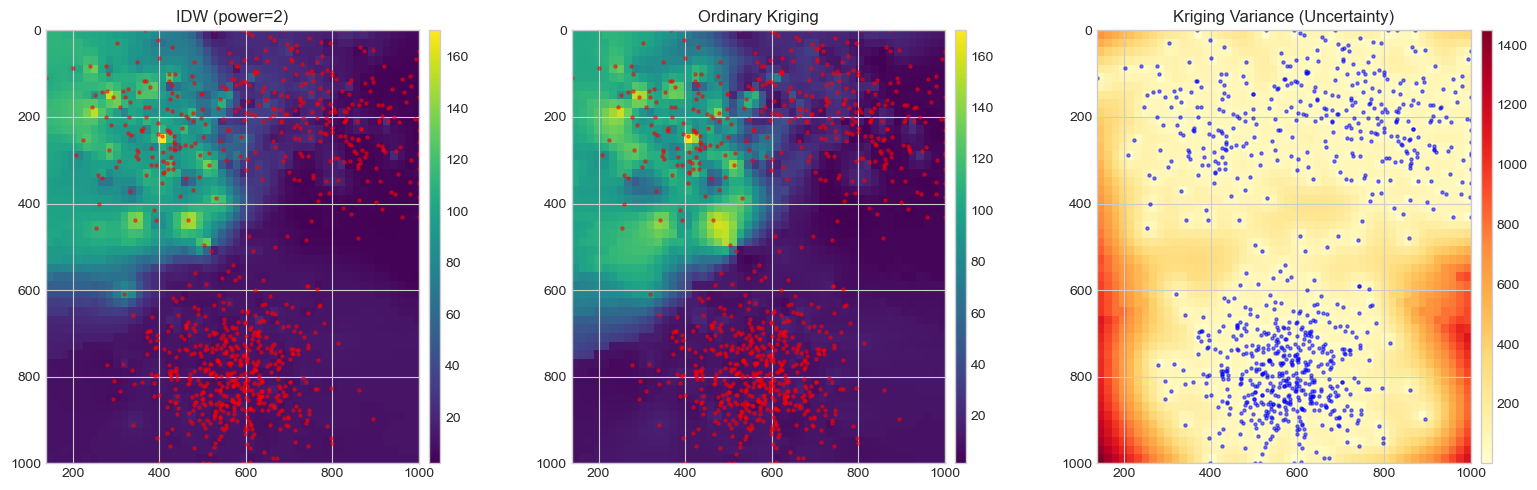


KRIGING ADVANTAGES:
-------------------
- Uses spatial structure (variogram) for optimal weighting
- Provides uncertainty estimates (kriging variance)
- Exact interpolator: passes through sample points
- Higher variance = less confidence (farther from samples)



In [22]:
# Apply kriging
print("Running Ordinary Kriging (this may take a moment)...")
kriging_pred, kriging_var = ordinary_kriging(
    sample_coords, sample_values, grid_points,
    nugget, sill, range_param, n_neighbors=12
)

# Compare IDW and Kriging
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# IDW
idw_grid = idw_p2.reshape(grid_resolution, grid_resolution)
h.plot_raster(idw_grid, ax=axes[0], title='IDW (power=2)', extent=extent, robust_stretch=False)
axes[0].scatter(sample_coords[:, 0], sample_coords[:, 1], c='red', s=5, alpha=0.5)

# Kriging prediction
kriging_grid = kriging_pred.reshape(grid_resolution, grid_resolution)
h.plot_raster(kriging_grid, ax=axes[1], title='Ordinary Kriging', extent=extent, robust_stretch=False)
axes[1].scatter(sample_coords[:, 0], sample_coords[:, 1], c='red', s=5, alpha=0.5)

# Kriging variance (uncertainty)
variance_grid = kriging_var.reshape(grid_resolution, grid_resolution)
h.plot_raster(variance_grid, ax=axes[2], title='Kriging Variance (Uncertainty)', 
              extent=extent, cmap='YlOrRd', robust_stretch=False)
axes[2].scatter(sample_coords[:, 0], sample_coords[:, 1], c='blue', s=5, alpha=0.5)

plt.tight_layout()
plt.show()

print("""
KRIGING ADVANTAGES:
-------------------
- Uses spatial structure (variogram) for optimal weighting
- Provides uncertainty estimates (kriging variance)
- Exact interpolator: passes through sample points
- Higher variance = less confidence (farther from samples)
""")

---

## 2.2 Principal Component Analysis (PCA)

PCA reduces dimensionality while preserving variance. Useful for:
- Identifying element associations
- Noise reduction
- Visualization of high-dimensional geochemical data

In [23]:
# Prepare data for PCA
X_geochem = gdf_geochem[element_cols].values

# Log transform (common for geochemical data)
X_log = np.log(X_geochem + 1)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

print(f"Original dimensions: {X_geochem.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Cumulative variance: {np.cumsum(pca.explained_variance_ratio_)}")

Original dimensions: 8
Explained variance ratio: [0.52185063 0.25881353 0.11208705 0.04393978 0.02546391 0.0148545
 0.01379249 0.00919812]
Cumulative variance: [0.52185063 0.78066416 0.89275121 0.93669099 0.96215489 0.97700939
 0.99080188 1.        ]


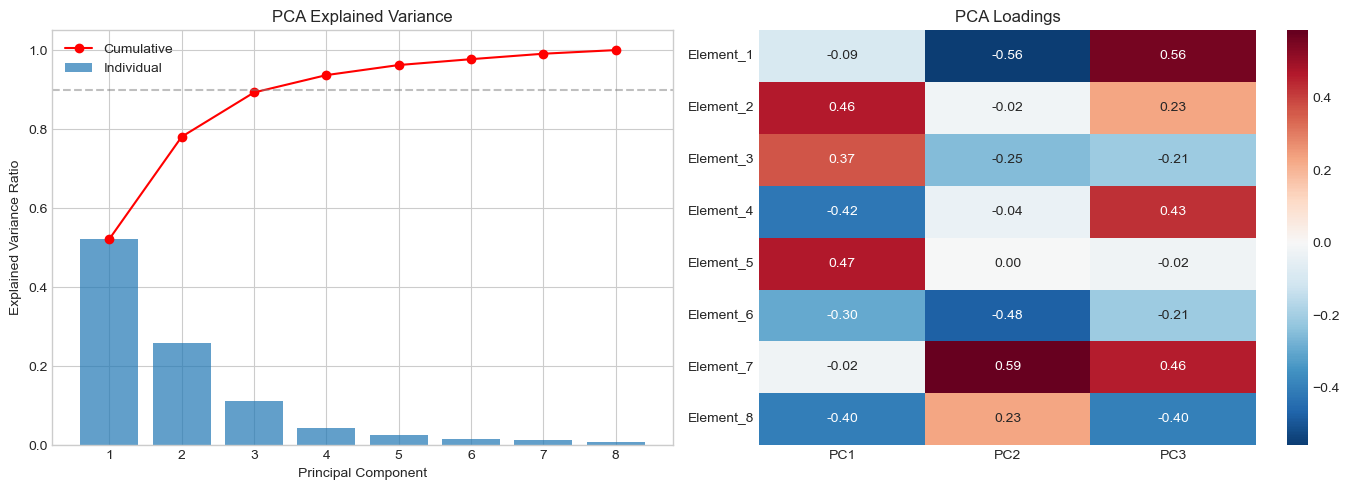


PCA INTERPRETATION:
-------------------
- PC1 often represents overall geochemical intensity
- Subsequent PCs capture orthogonal patterns (different processes)
- Loadings show which elements contribute to each PC
- Same-sign loadings: elements associated together
- Opposite-sign loadings: negatively correlated elements



In [24]:
# Visualize PCA results
fig, axes = h.plot_pca_results(pca, element_cols, figsize=(14, 5))
plt.show()

print("""
PCA INTERPRETATION:
-------------------
- PC1 often represents overall geochemical intensity
- Subsequent PCs capture orthogonal patterns (different processes)
- Loadings show which elements contribute to each PC
- Same-sign loadings: elements associated together
- Opposite-sign loadings: negatively correlated elements
""")

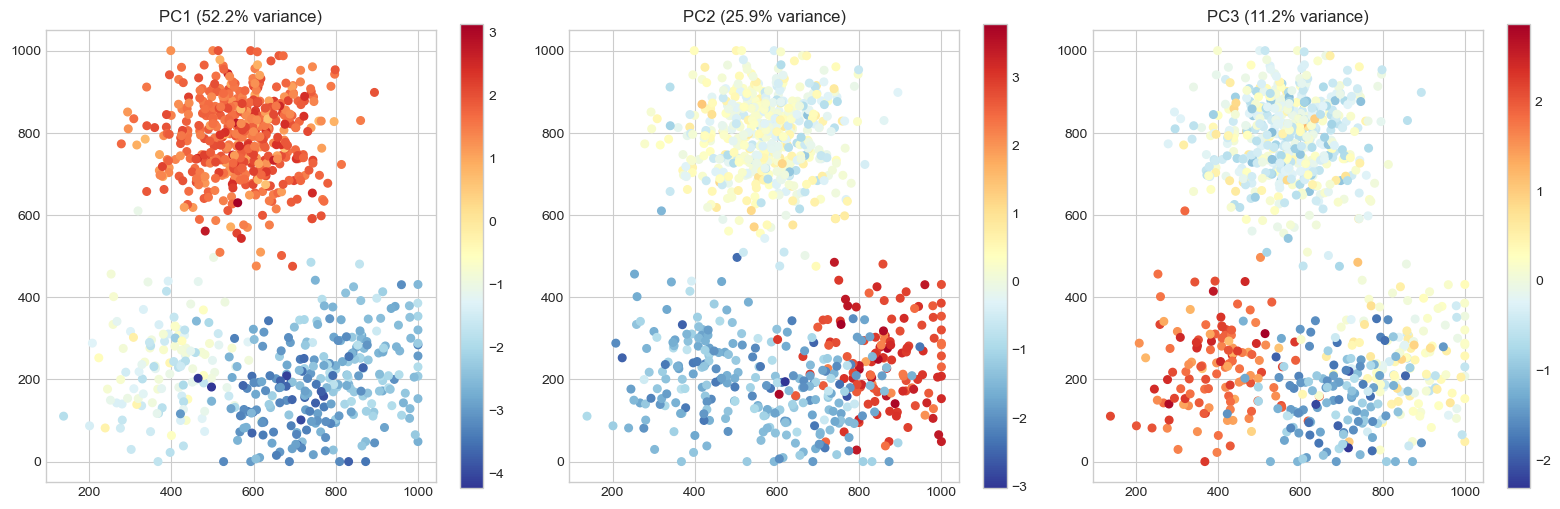

In [25]:
# Spatial visualization of principal components
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, ax in enumerate(axes):
    gdf_temp = gdf_geochem.copy()
    gdf_temp[f'PC{i+1}'] = X_pca[:, i]
    gdf_temp.plot(column=f'PC{i+1}', ax=ax, legend=True, cmap='RdYlBu_r', markersize=30)
    ax.set_title(f'PC{i+1} ({pca.explained_variance_ratio_[i]*100:.1f}% variance)')

plt.tight_layout()
plt.show()

---

## 2.3 K-Means Clustering

K-means groups samples into K clusters based on similarity. Useful for:
- Identifying distinct geochemical populations
- Lithology/alteration classification
- Data segmentation

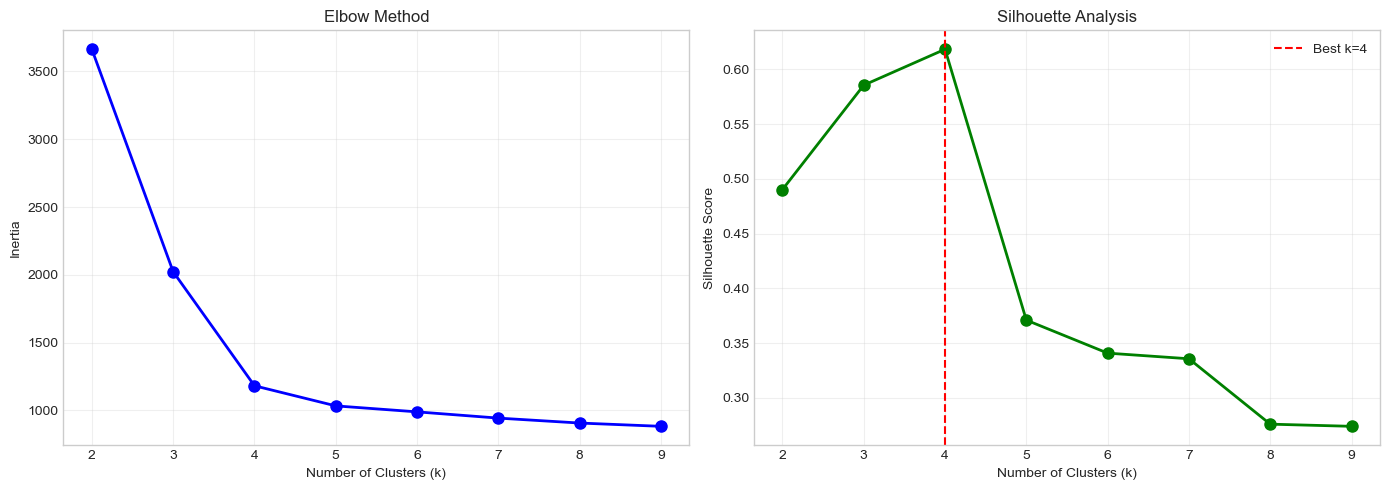

Optimal number of clusters (by silhouette): 4


In [26]:
# Find optimal number of clusters using elbow method and silhouette score
k_range = range(2, 10)
inertias = []
silhouettes = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

fig, axes = h.plot_elbow_silhouette(list(k_range), inertias, silhouettes, figsize=(14, 5))
plt.show()

# Find optimal k
optimal_k = list(k_range)[np.argmax(silhouettes)]
print(f"Optimal number of clusters (by silhouette): {optimal_k}")

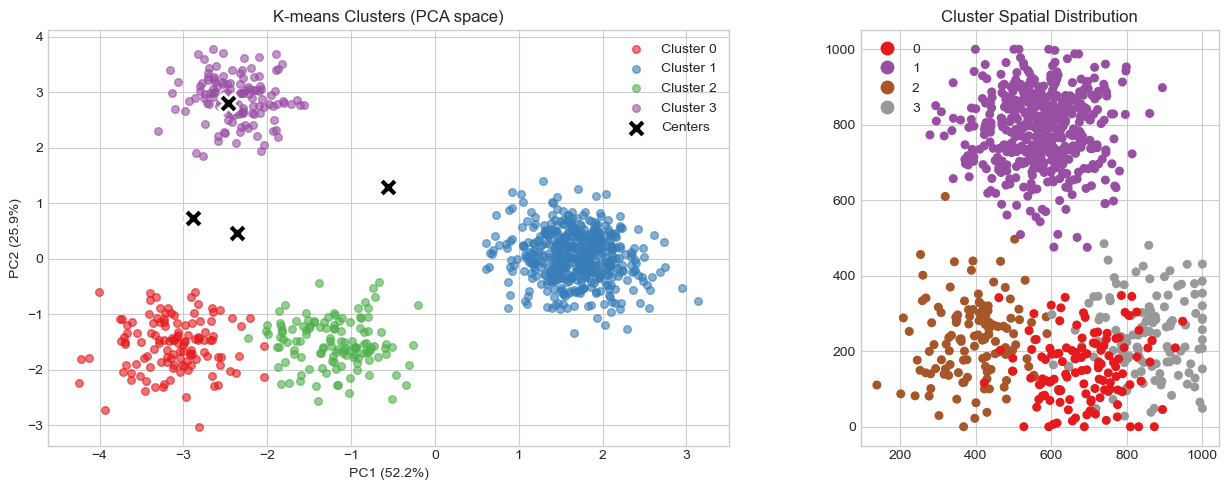

In [27]:
# Apply K-means with optimal k
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Visualize in PCA space
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PCA biplot with clusters
h.plot_clustering_results(X_pca, cluster_labels, 
                          centers=pca.transform(scaler.transform(np.log(kmeans_final.cluster_centers_.clip(min=0) + 1))),
                          title='K-means Clusters (PCA space)', ax=axes[0],
                          feature_x=0, feature_y=1)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')

# Spatial distribution of clusters
gdf_clustered = gdf_geochem.copy()
gdf_clustered['cluster'] = cluster_labels
gdf_clustered.plot(column='cluster', ax=axes[1], legend=True, 
                   categorical=True, cmap='Set1', markersize=30)
axes[1].set_title('Cluster Spatial Distribution')

plt.tight_layout()
plt.show()

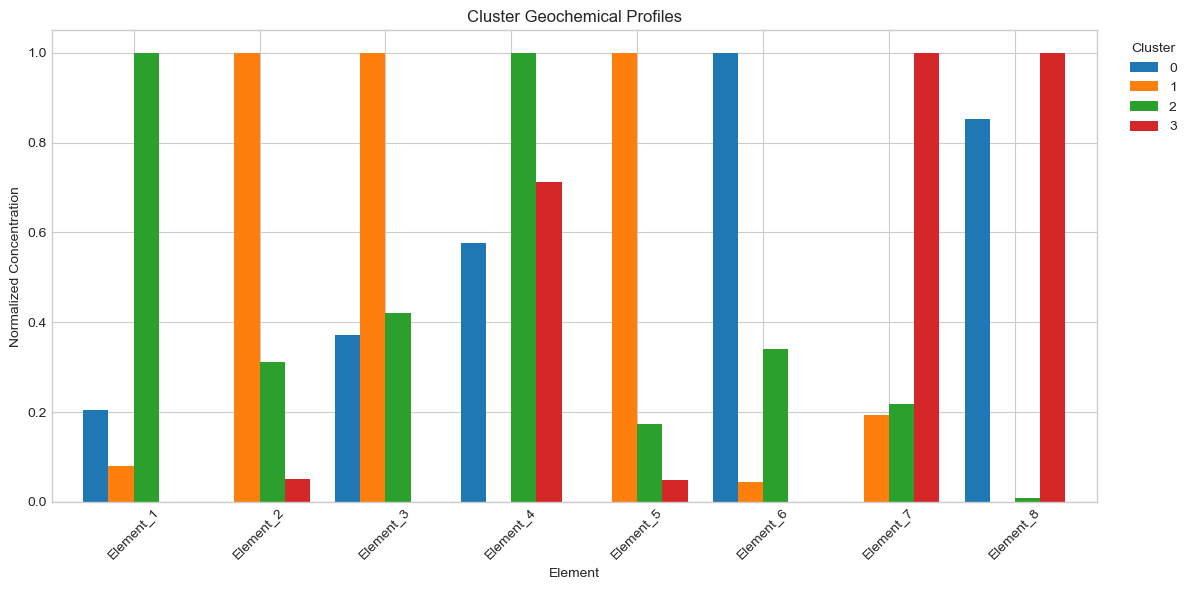


CLUSTER INTERPRETATION:
-----------------------
Each cluster represents a distinct geochemical population.
High values indicate enrichment in that cluster.
Use domain knowledge to interpret geological meaning:
- Lithological units
- Alteration assemblages
- Mineralization styles



In [28]:
# Cluster profiles (mean element concentrations per cluster)
gdf_clustered['cluster'] = cluster_labels

cluster_profiles = gdf_clustered.groupby('cluster')[element_cols].mean()

# Normalize for comparison
cluster_profiles_norm = (cluster_profiles - cluster_profiles.min()) / (cluster_profiles.max() - cluster_profiles.min())

fig, ax = plt.subplots(figsize=(12, 6))
cluster_profiles_norm.T.plot(kind='bar', ax=ax, width=0.8)
ax.set_xlabel('Element')
ax.set_ylabel('Normalized Concentration')
ax.set_title('Cluster Geochemical Profiles')
ax.legend(title='Cluster', bbox_to_anchor=(1.02, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("""
CLUSTER INTERPRETATION:
-----------------------
Each cluster represents a distinct geochemical population.
High values indicate enrichment in that cluster.
Use domain knowledge to interpret geological meaning:
- Lithological units
- Alteration assemblages
- Mineralization styles
""")

---

## 2.4 Multivariate Anomaly Detection

Anomaly detection identifies unusual samples that deviate from the background population. Useful for:
- Identifying mineralization-related geochemical signatures
- Quality control (detecting contaminated samples)
- Exploration targeting

### Isolation Forest

Isolation Forest isolates anomalies by randomly partitioning data. Anomalies require fewer partitions to isolate.

In [29]:
# Apply Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
anomaly_labels = iso_forest.fit_predict(X_scaled)
anomaly_scores = -iso_forest.decision_function(X_scaled)  # Higher = more anomalous

# Normalize scores to 0-1
anomaly_scores_norm = (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min())

print(f"Number of anomalies detected: {(anomaly_labels == -1).sum()} ({(anomaly_labels == -1).mean()*100:.1f}%)")

Number of anomalies detected: 44 (5.0%)


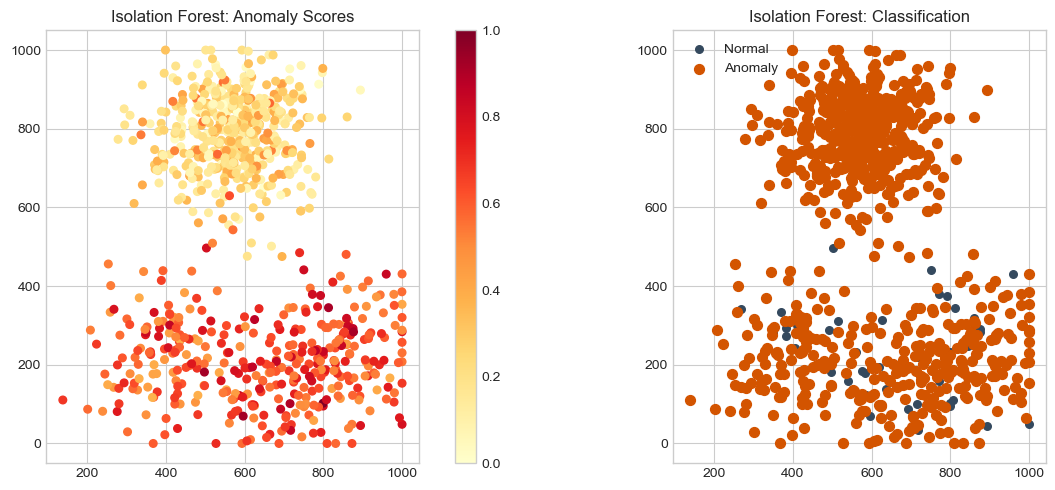

In [30]:
# Visualize anomaly detection results
gdf_anomaly = gdf_geochem.copy()
gdf_anomaly['anomaly_score'] = anomaly_scores_norm
gdf_anomaly['is_anomaly'] = anomaly_labels

fig, axes = h.plot_anomaly_scores(
    gdf_anomaly, anomaly_scores_norm, 
    binary_labels=anomaly_labels,
    title='Isolation Forest',
    figsize=(14, 5)
)
plt.show()

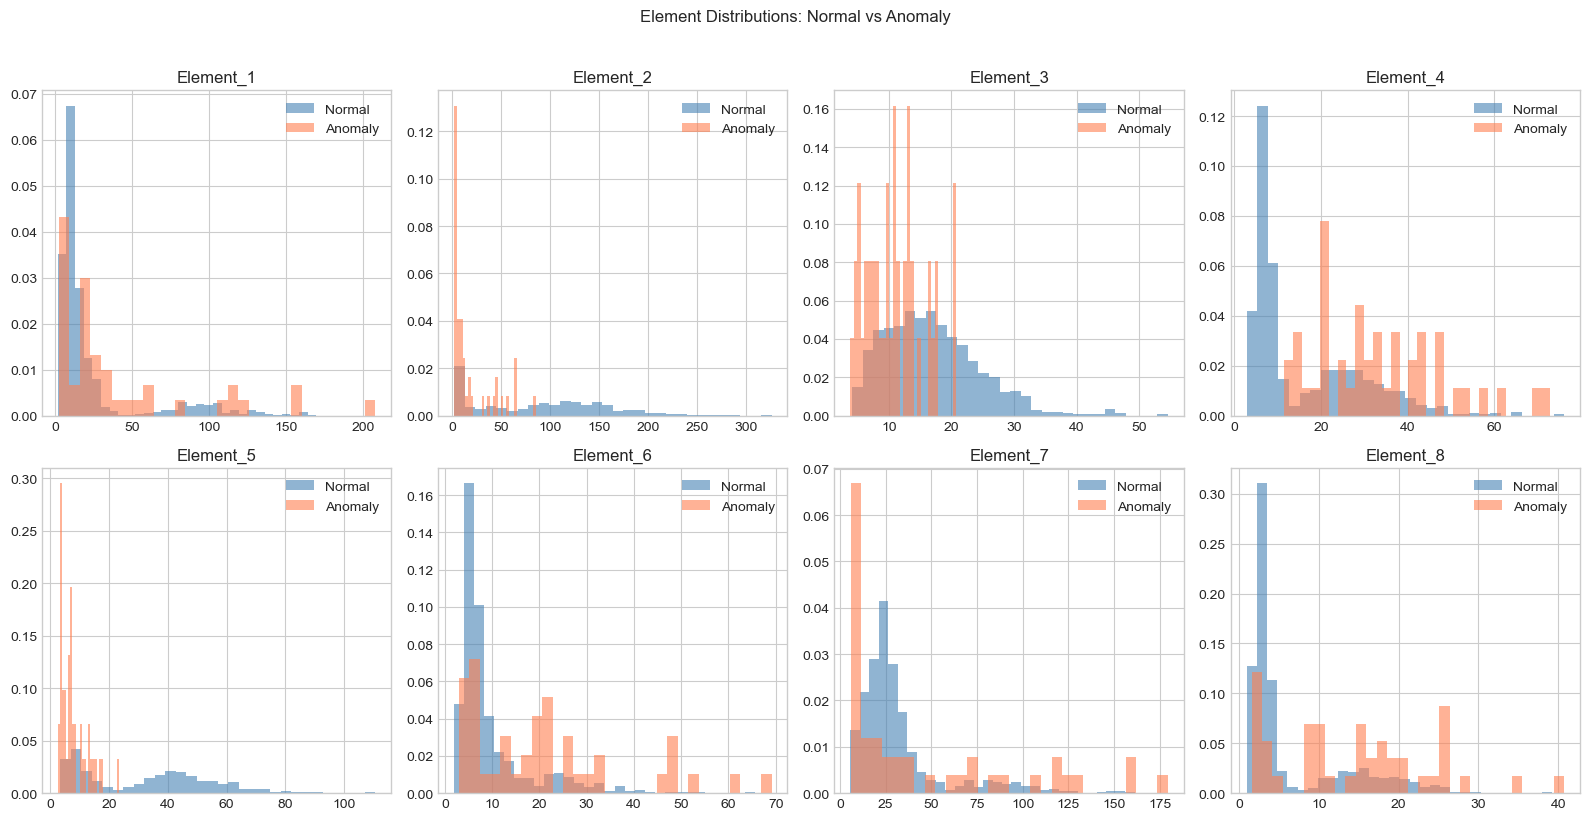


ANOMALY DETECTION INSIGHTS:
---------------------------
- Anomalies often show enrichment in specific elements
- Multi-element anomalies are more robust than single-element
- Compare against known deposits/occurrences for validation
- Consider geological context when interpreting anomalies



In [31]:
# Compare anomalies vs normal samples
anomaly_mask = anomaly_labels == -1

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(element_cols[:8]):
    axes[i].hist(gdf_anomaly.loc[~anomaly_mask, col], bins=30, alpha=0.6, 
                 label='Normal', color='steelblue', density=True)
    axes[i].hist(gdf_anomaly.loc[anomaly_mask, col], bins=30, alpha=0.6, 
                 label='Anomaly', color='coral', density=True)
    axes[i].set_title(col)
    axes[i].legend()

plt.suptitle('Element Distributions: Normal vs Anomaly', y=1.02)
plt.tight_layout()
plt.show()

print("""
ANOMALY DETECTION INSIGHTS:
---------------------------
- Anomalies often show enrichment in specific elements
- Multi-element anomalies are more robust than single-element
- Compare against known deposits/occurrences for validation
- Consider geological context when interpreting anomalies
""")

---

## 2.5 Spectral Halo Classification

Spectral indices from remote sensing can identify alteration mineralogy. This unsupervised approach:
1. Computes spectral indices (e.g., clay, iron oxide, vegetation indicators)
2. Generates kernel density estimates (KDE) for each index
3. Uses K-means to identify high-density "halo" regions
4. Combines weighted indices to classify alteration types

Reference: Implementation based on `MinersWork/spectral_unsupervised/spectral_unsupervised_class.ipynb`

In [32]:
# Generate synthetic spectral indices for demonstration
# In practice, these would be computed from multispectral imagery

np.random.seed(42)
raster_shape = (100, 100)

def generate_spectral_index(shape, n_anomalies=3, background=0.3, anomaly_strength=0.4):
    """Generate synthetic spectral index with anomalous regions."""
    data = np.random.normal(background, 0.1, shape)
    
    for _ in range(n_anomalies):
        cx, cy = np.random.randint(20, 80, 2)
        radius = np.random.randint(10, 25)
        y, x = np.ogrid[:shape[0], :shape[1]]
        mask = ((x - cx)**2 + (y - cy)**2) < radius**2
        data[mask] += np.random.uniform(anomaly_strength * 0.5, anomaly_strength)
    
    return np.clip(data, 0, 1)

# Generate multiple spectral indices
spectral_indices = {
    'Clay_AlOH': generate_spectral_index(raster_shape, n_anomalies=4),
    'Iron_Oxide': generate_spectral_index(raster_shape, n_anomalies=3),
    'Ferrous_Iron': generate_spectral_index(raster_shape, n_anomalies=2),
    'Carbonate': generate_spectral_index(raster_shape, n_anomalies=2),
    'Silica': generate_spectral_index(raster_shape, n_anomalies=3),
}

print(f"Generated {len(spectral_indices)} spectral indices")
print(f"Raster shape: {raster_shape}")

Generated 5 spectral indices
Raster shape: (100, 100)


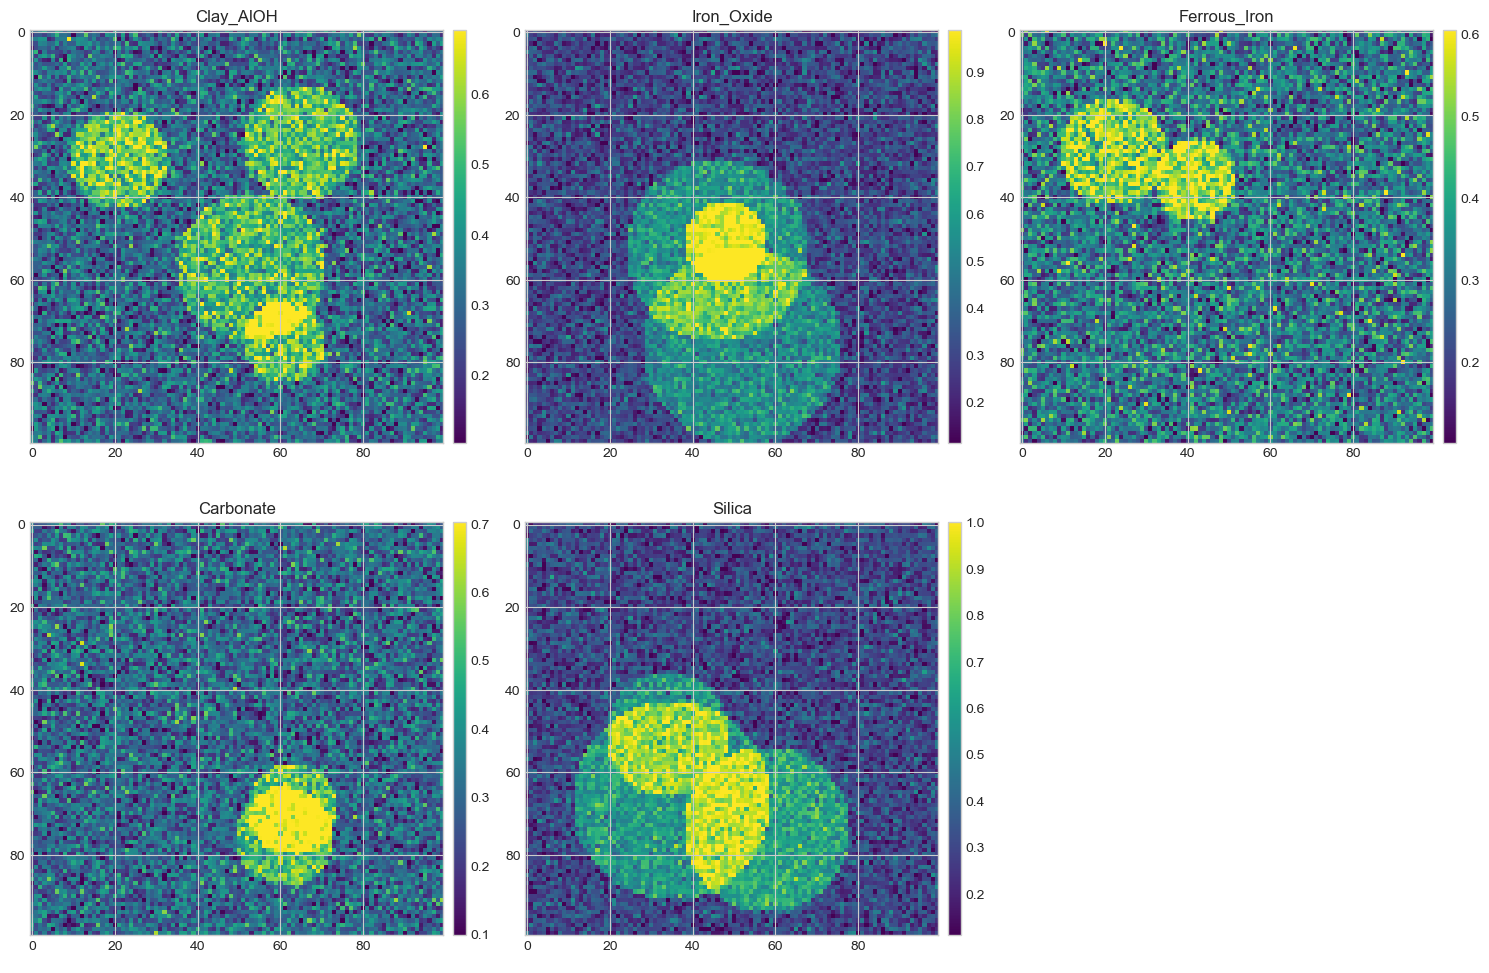

In [33]:
# Visualize spectral indices
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, (name, data) in zip(axes, spectral_indices.items()):
    h.plot_raster(data, ax=ax, title=name, cmap='viridis', robust_stretch=True)

# Hide extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

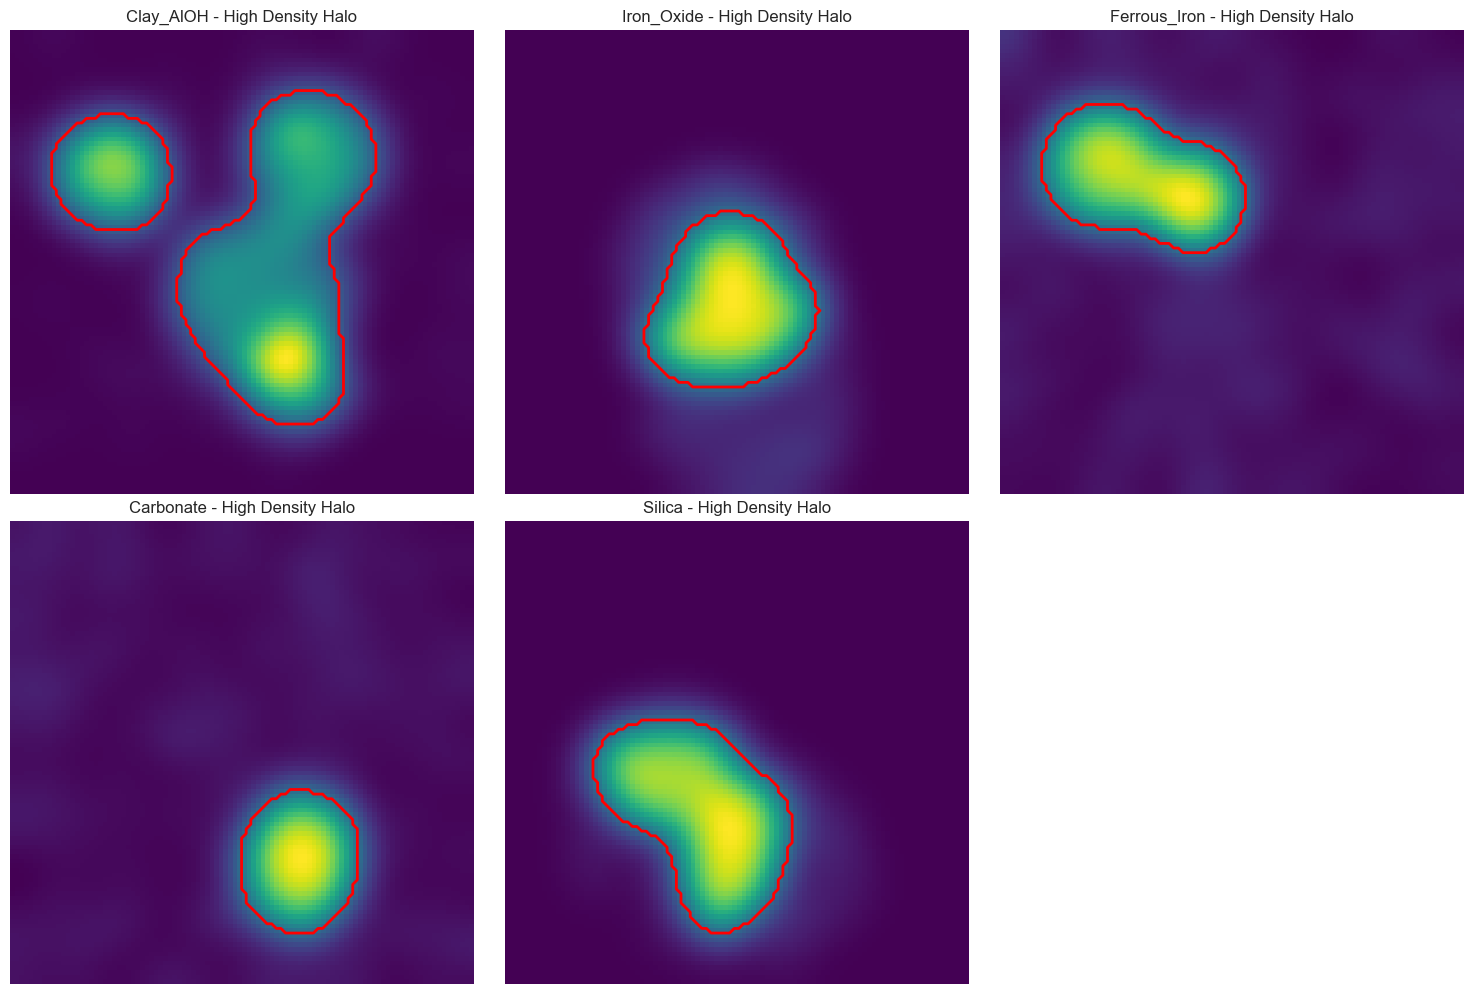

In [34]:
def compute_halo_detection(index_data, percentile_threshold=90, sigma=5):
    """Detect high-density halos using KDE and K-means."""
    # Robust z-scoring
    p1, p99 = np.percentile(index_data, [1, 99])
    clipped = np.clip(index_data, p1, p99)
    median_val = np.median(clipped)
    iqr = np.percentile(clipped, 75) - np.percentile(clipped, 25)
    z_scored = (clipped - median_val) / (iqr + 1e-10)
    
    # Presence mask (top percentile)
    threshold = np.percentile(z_scored, percentile_threshold)
    presence_mask = z_scored >= threshold
    
    # KDE via Gaussian filter
    kde_surface = ndimage.gaussian_filter(presence_mask.astype(float), sigma=sigma)
    
    # K-means to split high/low density
    kde_flat = kde_surface.flatten().reshape(-1, 1)
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(kde_flat).reshape(index_data.shape)
    
    # Identify high-density cluster
    cluster_means = [kde_surface[cluster_labels == i].mean() for i in range(2)]
    high_density_label = np.argmax(cluster_means)
    high_density_mask = cluster_labels == high_density_label
    
    return kde_surface, high_density_mask

# Apply halo detection to all indices
kde_surfaces = {}
halo_masks = {}

for name, data in spectral_indices.items():
    kde, mask = compute_halo_detection(data)
    kde_surfaces[name] = kde
    halo_masks[name] = mask

# Visualize halo detection results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, (name, kde) in zip(axes, kde_surfaces.items()):
    # Show KDE with halo overlay
    ax.imshow(kde, cmap='viridis', origin='upper')
    ax.contour(halo_masks[name], levels=[0.5], colors='red', linewidths=2)
    ax.set_title(f'{name} - High Density Halo')
    ax.axis('off')

axes[-1].axis('off')
plt.tight_layout()
plt.show()

In [35]:
# Alteration type classification using weighted combination
# Weights based on typical alteration assemblages

alteration_weights = {
    'Advanced Argillic': {'Clay_AlOH': 0.4, 'Silica': 0.3, 'Iron_Oxide': 0.2, 'Ferrous_Iron': 0.1},
    'Phyllic': {'Clay_AlOH': 0.5, 'Iron_Oxide': 0.3, 'Silica': 0.2},
    'Propylitic': {'Carbonate': 0.4, 'Ferrous_Iron': 0.3, 'Clay_AlOH': 0.3},
    'Gossan': {'Iron_Oxide': 0.5, 'Ferrous_Iron': 0.3, 'Silica': 0.2},
}

def normalize_kde(kde, percentile_low=2, percentile_high=98):
    """Robust normalization of KDE surface."""
    p_low, p_high = np.percentile(kde, [percentile_low, percentile_high])
    normalized = (kde - p_low) / (p_high - p_low + 1e-10)
    return np.clip(normalized, 0, 1)

# Normalize all KDE surfaces
kde_normalized = {name: normalize_kde(kde) for name, kde in kde_surfaces.items()}

# Compute weighted scores for each alteration type
alteration_scores = {}
for alt_type, weights in alteration_weights.items():
    score = np.zeros(raster_shape)
    for index_name, weight in weights.items():
        if index_name in kde_normalized:
            score += weight * kde_normalized[index_name]
    alteration_scores[alt_type] = score

# Classify based on highest score
all_scores = np.stack([alteration_scores[k] for k in alteration_weights.keys()], axis=-1)
class_map = np.argmax(all_scores, axis=-1) + 1  # 1-indexed classes

# Mask low-confidence areas
max_scores = np.max(all_scores, axis=-1)
confidence_threshold = 0.2
class_map[max_scores < confidence_threshold] = 0  # Background

print("Alteration type classes:")
print("0: Background")
for i, name in enumerate(alteration_weights.keys(), 1):
    count = (class_map == i).sum()
    print(f"{i}: {name} ({count} pixels, {count/class_map.size*100:.1f}%)")

Alteration type classes:
0: Background
1: Advanced Argillic (446 pixels, 4.5%)
2: Phyllic (1501 pixels, 15.0%)
3: Propylitic (1140 pixels, 11.4%)
4: Gossan (497 pixels, 5.0%)


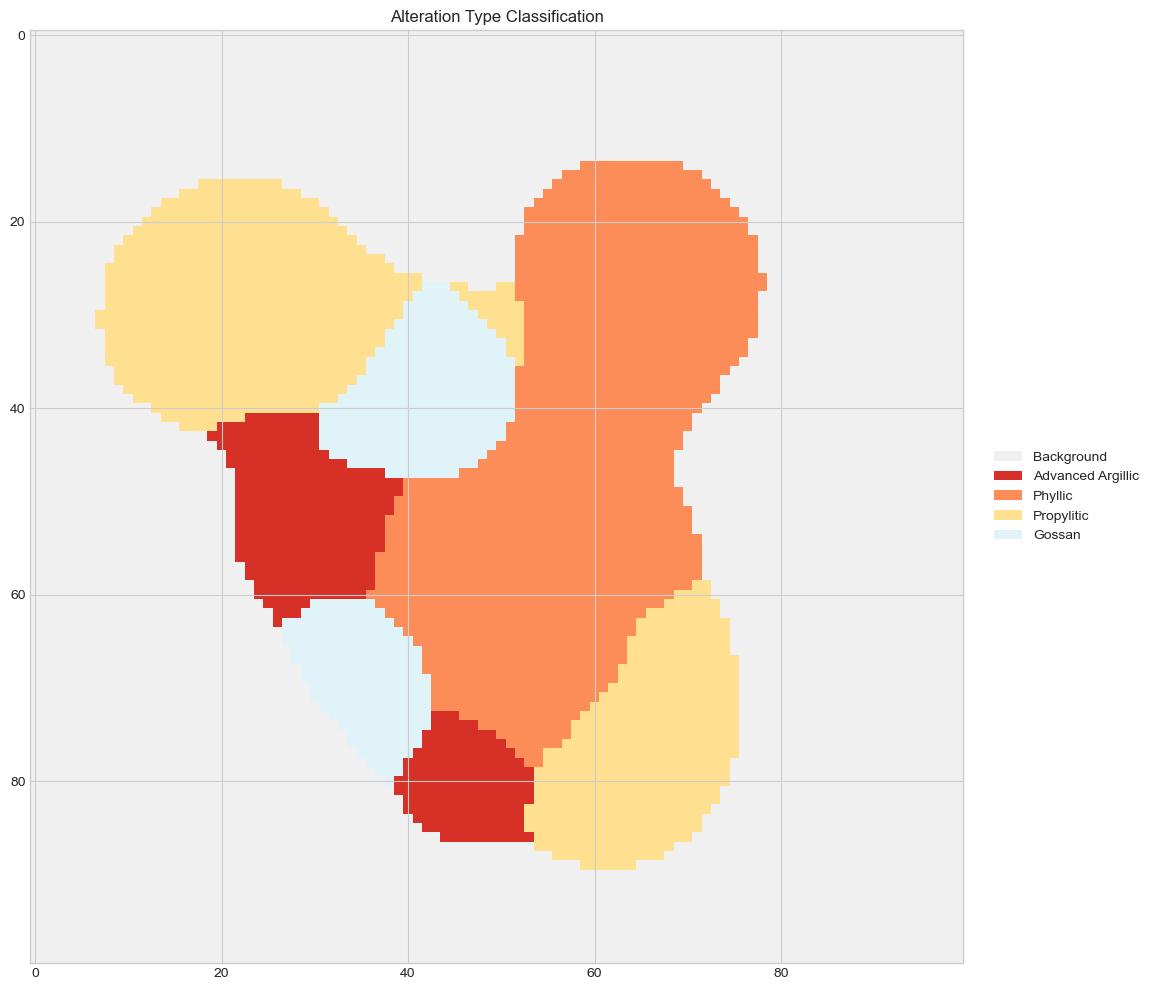


SPECTRAL HALO CLASSIFICATION:
-----------------------------
This unsupervised approach identifies alteration types based on:
1. Spectral index values (proxy for mineralogy)
2. Spatial density patterns (KDE)
3. Weighted combinations based on expected assemblages

Validation should include:
- Field verification of predicted alteration types
- Comparison with known mineralization
- Cross-validation with other datasets (geochemistry, geophysics)



In [36]:
# Visualize alteration classification
class_names = ['Background'] + list(alteration_weights.keys())
fig, ax = h.plot_alteration_map(class_map, class_names=class_names, figsize=(12, 10))
plt.show()

print("""
SPECTRAL HALO CLASSIFICATION:
-----------------------------
This unsupervised approach identifies alteration types based on:
1. Spectral index values (proxy for mineralogy)
2. Spatial density patterns (KDE)
3. Weighted combinations based on expected assemblages

Validation should include:
- Field verification of predicted alteration types
- Comparison with known mineralization
- Cross-validation with other datasets (geochemistry, geophysics)
""")

---

## 2.6 Supervised ML Prospectivity Mapping

Prospectivity mapping predicts the probability of mineralization at each location using:
- **Features**: Geochemistry, geophysics, geology, remote sensing, proximity to structures, etc.
- **Labels**: Known deposit locations (positive) vs background (negative)
- **Output**: Probability map indicating prospectivity

Reference: Implementation based on `supervised_ML/` directory

In [37]:
# Generate synthetic training data for demonstration
# In practice, this would come from compiled feature layers and known deposits

np.random.seed(42)

# Create multi-layer feature raster
n_features = 8
map_shape = (100, 100)
n_pixels = map_shape[0] * map_shape[1]

# Generate feature layers with spatial correlation
feature_names = ['Geochem_PC1', 'Geochem_PC2', 'Mag_RTP', 'Gravity_Bouguer', 
                 'Dist_to_Fault', 'Lithology_Code', 'Alteration_Index', 'Slope']

features = {}
for name in feature_names:
    # Create spatially correlated random field
    raw = np.random.randn(*map_shape)
    smoothed = ndimage.gaussian_filter(raw, sigma=10)
    features[name] = smoothed

# Stack features into array
X_raster = np.stack([features[name] for name in feature_names], axis=-1)
X_flat = X_raster.reshape(-1, n_features)

# Generate synthetic deposit locations (target variable)
# Deposits cluster in areas with specific feature combinations
prospectivity_true = (
    0.3 * features['Geochem_PC1'] + 
    0.2 * features['Alteration_Index'] + 
    0.2 * features['Mag_RTP'] - 
    0.1 * features['Dist_to_Fault'] +
    0.2 * np.random.randn(*map_shape) * 0.5
)

# Convert to binary (mineralized vs non-mineralized)
threshold = np.percentile(prospectivity_true, 95)  # Top 5% are mineralized
y_raster = (prospectivity_true >= threshold).astype(int)
y_flat = y_raster.flatten()

print(f"Feature array shape: {X_flat.shape}")
print(f"Target shape: {y_flat.shape}")
print(f"Positive class rate: {y_flat.mean()*100:.1f}%")

Feature array shape: (10000, 8)
Target shape: (10000,)
Positive class rate: 5.0%


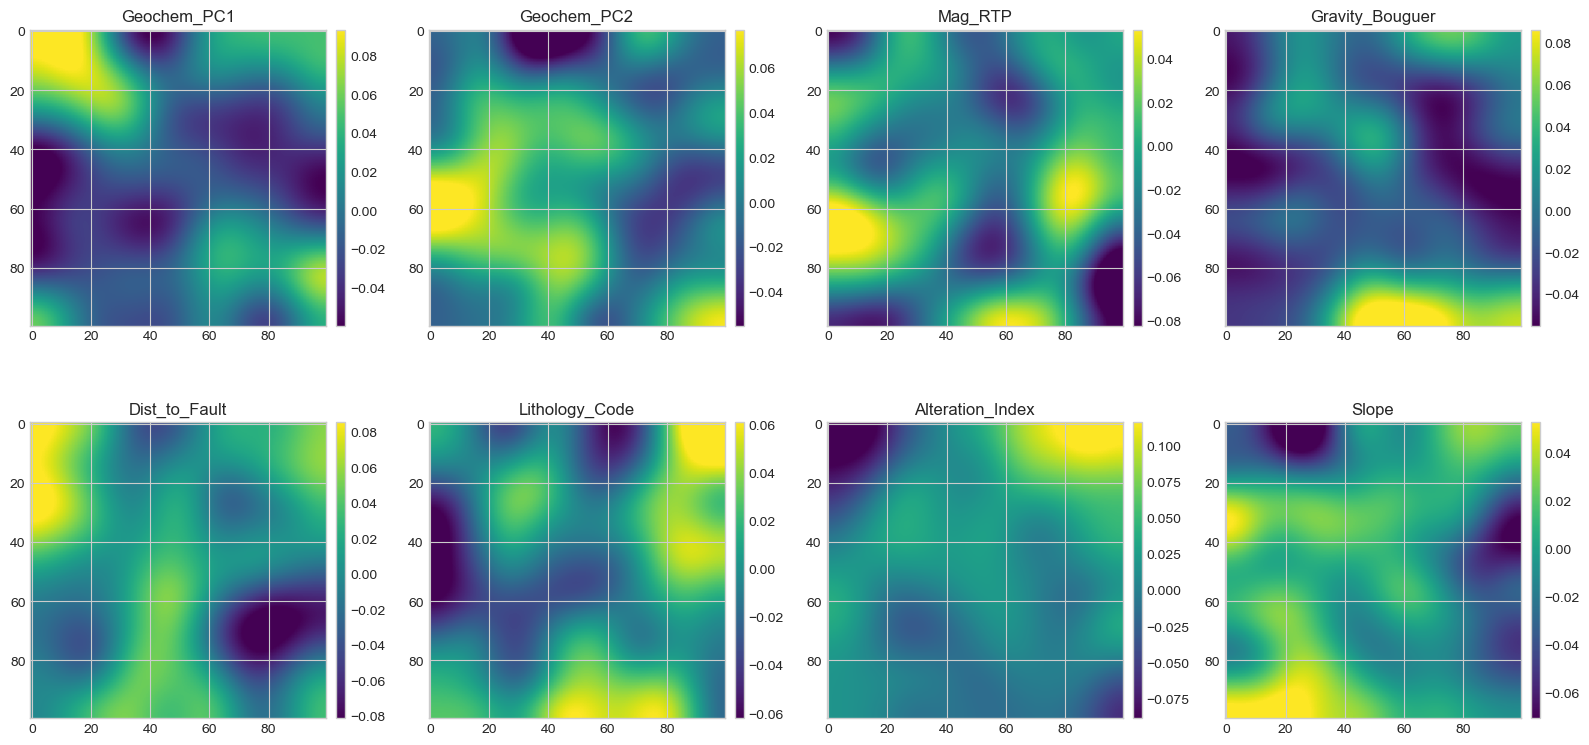

In [38]:
# Visualize feature layers
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for ax, name in zip(axes, feature_names):
    h.plot_raster(features[name], ax=ax, title=name, robust_stretch=True)

plt.tight_layout()
plt.show()

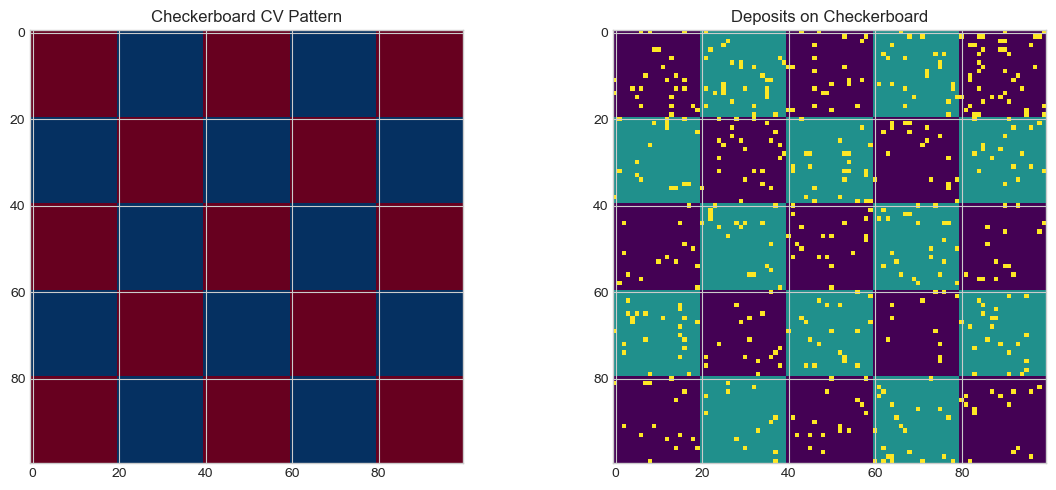

Checker 0 pixels: 5200
Checker 1 pixels: 4800


In [39]:
# Spatial cross-validation using checkerboard pattern
# This prevents data leakage from spatial autocorrelation

def create_checkerboard_mask(shape, tile_size=20):
    """Create checkerboard pattern for spatial CV."""
    rows, cols = shape
    y_idx, x_idx = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')
    
    # Checkerboard based on tile position
    tile_y = y_idx // tile_size
    tile_x = x_idx // tile_size
    checker = (tile_y + tile_x) % 2
    
    return checker

checker_mask = create_checkerboard_mask(map_shape, tile_size=20)

# Visualize checkerboard pattern
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(checker_mask, cmap='RdBu', origin='upper')
axes[0].set_title('Checkerboard CV Pattern')

# Show deposits on checkerboard
overlay = checker_mask.copy().astype(float)
overlay[y_raster == 1] = 2
axes[1].imshow(overlay, cmap='viridis', origin='upper')
axes[1].set_title('Deposits on Checkerboard')

plt.tight_layout()
plt.show()

print(f"Checker 0 pixels: {(checker_mask == 0).sum()}")
print(f"Checker 1 pixels: {(checker_mask == 1).sum()}")

In [40]:
# Train prospectivity model using Random Forest
# (CatBoost used in reference implementation, but RF is simpler for demo)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Flatten checker mask
checker_flat = checker_mask.flatten()

# Split data using checkerboard
train_mask = checker_flat == 0
test_mask = checker_flat == 1

X_train, X_test = X_flat[train_mask], X_flat[test_mask]
y_train, y_test = y_flat[train_mask], y_flat[test_mask]

print(f"Training samples: {len(X_train)} (positive: {y_train.sum()})")
print(f"Test samples: {len(X_test)} (positive: {y_test.sum()})")

# Handle class imbalance with class weights
class_weight = {0: 1, 1: (y_train == 0).sum() / (y_train == 1).sum()}
print(f"\nClass weight for positive class: {class_weight[1]:.1f}")

# Train model
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight=class_weight,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
print("\nModel trained successfully.")

Training samples: 5200 (positive: 252)
Test samples: 4800 (positive: 248)

Class weight for positive class: 19.6

Model trained successfully.


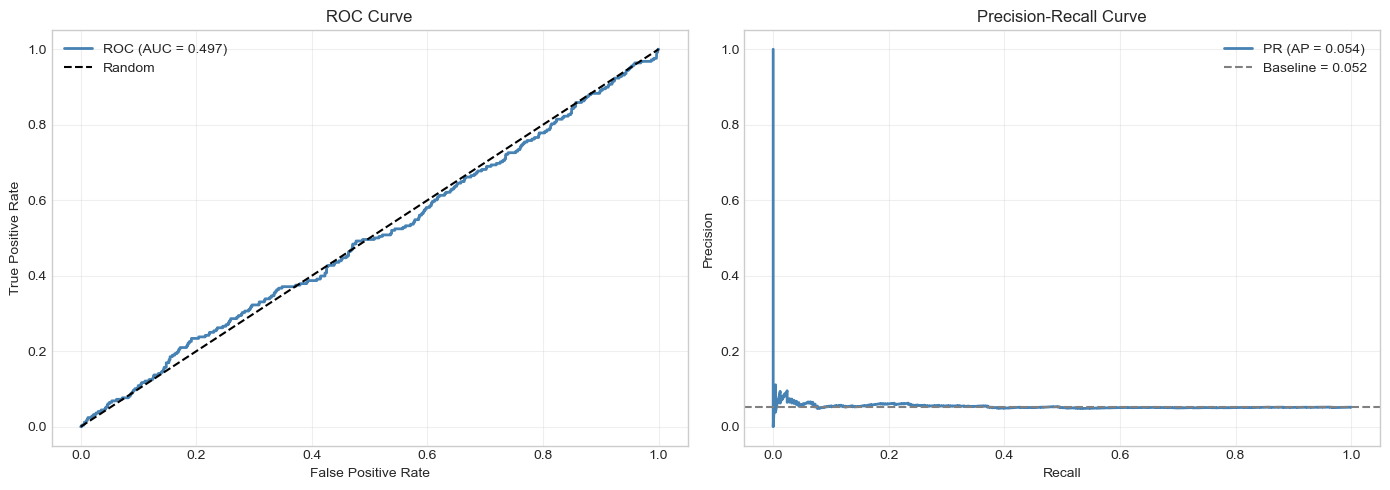


MODEL EVALUATION NOTES:
-----------------------
- ROC AUC: Overall discrimination ability (0.5 = random, 1.0 = perfect)
- PR AUC: More informative for imbalanced data
- Compare against baseline (class proportion) for PR curves
- Spatial CV provides realistic performance estimate



In [41]:
# Evaluate model performance
y_prob_test = model.predict_proba(X_test)[:, 1]

fig, axes = h.plot_roc_pr_curves(y_test, y_prob_test, figsize=(14, 5))
plt.show()

print("""
MODEL EVALUATION NOTES:
-----------------------
- ROC AUC: Overall discrimination ability (0.5 = random, 1.0 = perfect)
- PR AUC: More informative for imbalanced data
- Compare against baseline (class proportion) for PR curves
- Spatial CV provides realistic performance estimate
""")

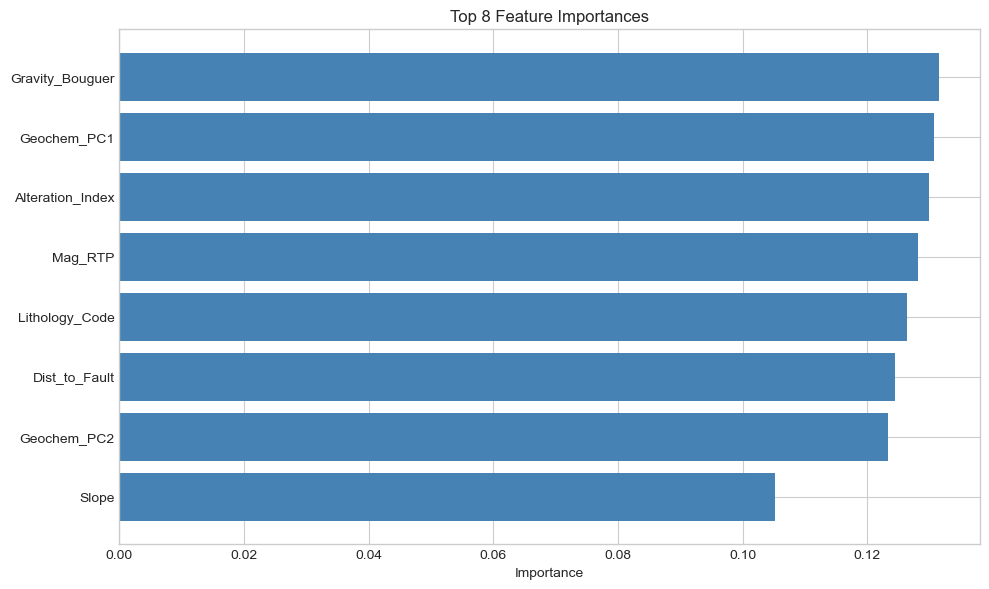


Feature importance ranking:
         feature  importance
 Gravity_Bouguer    0.131517
     Geochem_PC1    0.130714
Alteration_Index    0.129923
         Mag_RTP    0.128225
  Lithology_Code    0.126454
   Dist_to_Fault    0.124499
     Geochem_PC2    0.123407
           Slope    0.105261


In [42]:
# Feature importance
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

fig, ax = h.plot_feature_importance(importance_df, top_n=8, figsize=(10, 6))
plt.show()

print("\nFeature importance ranking:")
print(importance_df.to_string(index=False))

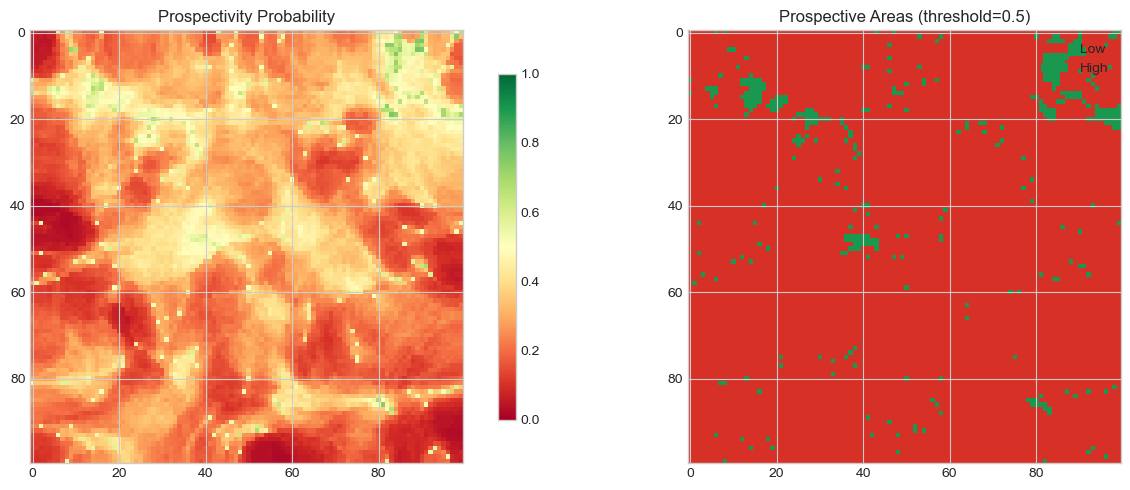

In [43]:
# Generate prospectivity map
y_prob_all = model.predict_proba(X_flat)[:, 1]
prob_map = y_prob_all.reshape(map_shape)

# Visualize prospectivity map
fig, axes = h.plot_prospectivity_map(prob_map, threshold=0.5, figsize=(14, 5))
plt.show()

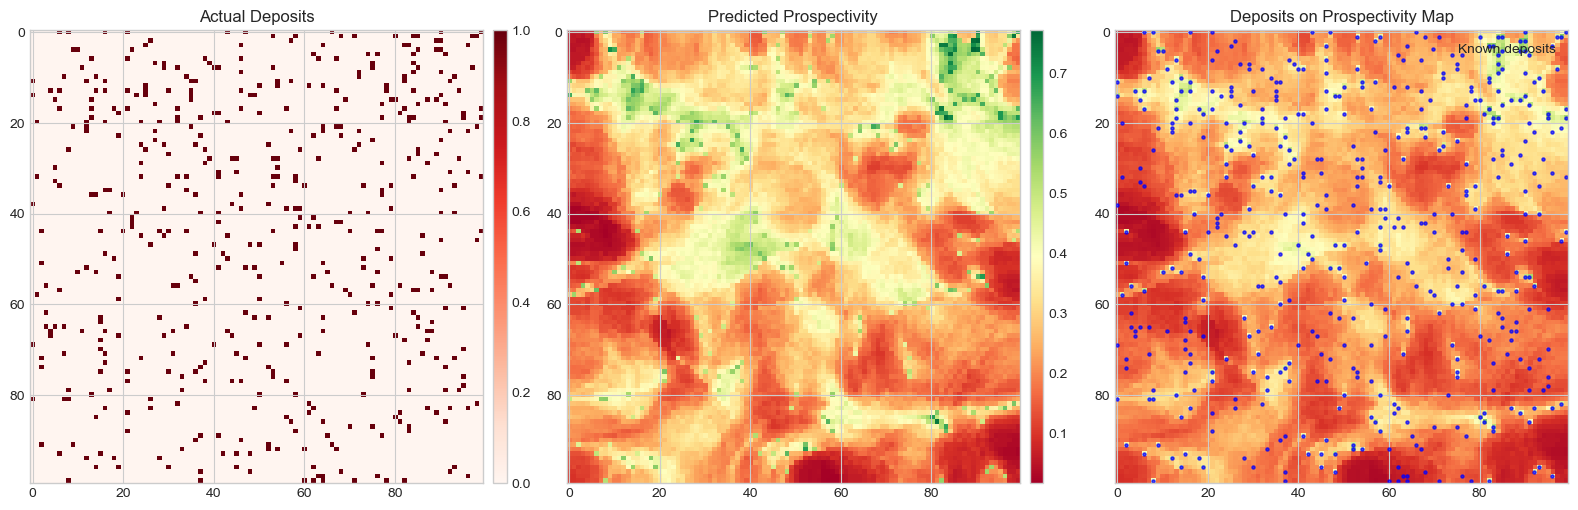


PROSPECTIVITY MAPPING SUMMARY:
------------------------------
1. Compile multi-layer feature dataset
2. Define positive (deposits) and negative (background) samples
3. Use spatial CV to prevent data leakage
4. Handle class imbalance with weights or sampling
5. Evaluate with appropriate metrics (PR-AUC for imbalanced data)
6. Generate probability map for exploration targeting
7. Validate with field work and additional data



In [44]:
# Compare predicted prospectivity with actual deposits
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# True deposits
h.plot_raster(y_raster.astype(float), ax=axes[0], title='Actual Deposits', 
              cmap='Reds', robust_stretch=False)

# Predicted probability
h.plot_raster(prob_map, ax=axes[1], title='Predicted Prospectivity', 
              cmap='RdYlGn', robust_stretch=False)

# Overlay: deposits on probability
axes[2].imshow(prob_map, cmap='RdYlGn', origin='upper', vmin=0, vmax=1)
deposit_y, deposit_x = np.where(y_raster == 1)
axes[2].scatter(deposit_x, deposit_y, c='blue', s=5, alpha=0.7, label='Known deposits')
axes[2].set_title('Deposits on Prospectivity Map')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

print("""
PROSPECTIVITY MAPPING SUMMARY:
------------------------------
1. Compile multi-layer feature dataset
2. Define positive (deposits) and negative (background) samples
3. Use spatial CV to prevent data leakage
4. Handle class imbalance with weights or sampling
5. Evaluate with appropriate metrics (PR-AUC for imbalanced data)
6. Generate probability map for exploration targeting
7. Validate with field work and additional data
""")

---

# Summary

This notebook covered the following geospatial ML concepts:

## Foundational Concepts
1. **Problem Formulation**: Defining the right question and approach
2. **Data Formats**: Raster vs vector, geometry types, continuous vs categorical
3. **EDA & Transformations**: Distribution analysis, log transforms, scaling methods
4. **Missing Data**: Visualization and imputation strategies
5. **Spatial Autocorrelation**: Understanding and accounting for spatial dependence

## Analytical Methods
1. **Interpolation**: IDW and Kriging for surface estimation
2. **PCA**: Dimensionality reduction and element associations
3. **K-means Clustering**: Identifying geochemical populations
4. **Anomaly Detection**: Isolation Forest for outlier identification
5. **Spectral Halo Classification**: Unsupervised alteration mapping
6. **Prospectivity Mapping**: Supervised ML for exploration targeting

## Key Takeaways
- Always account for spatial autocorrelation in geospatial ML
- Use appropriate transformations for geochemical data
- Validate results with domain knowledge and field data
- Combine multiple methods for robust interpretations

---

## Next Steps

To apply these methods to your own data:
1. Update the file paths in the configuration section
2. Adjust parameters based on your data characteristics
3. Validate results against known geology and mineralization
4. Iterate and refine based on field verification